In [4]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on May 29 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. Place results in the RESULT_FOLDER. These files can be taken from Tigress; /Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May23/
    IMAGES_FOLDER and TESTING_FOLDER will be filled during the analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
#name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'

############################################################
    
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
RESULT_FOLDER=PSF_DIRECTORY+'TigerAnalysis/ResultsFromTiger/May23/'
IMAGES_FOLDER=PSF_DIRECTORY+'Images/May23/'
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'

import os

for i in [PSF_DIRECTORY,DATA_FOLDER,RESULT_FOLDER,IMAGES_FOLDER,TESTING_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    
    

In [1405]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}


<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1447]:
#import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
import pandas as pd
import io
from tqdm import tqdm

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

# Analysis of many images at the same time 

In [1418]:
# init class
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=18000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
#import ptemcee
import time
import sys
from emcee.utils import MPIPool

from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

import astropy
import astropy.convolution
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D

np.seterr(divide='ignore', invalid='ignore')

__all__ = ['PupilFactory', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,slitFrac,slitFrac_dy,minorAxis,pupilAngle):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        #self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac
        self.slitFrac_dy=slitFrac_dy
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        np.save(TESTING_FOLDER+'fullPupililluminated',illuminated) 
        return Pupil(illuminated, self.pupilSize, self.pupilScale)       

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False
        
    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        np.save(TESTING_FOLDER+'selfu',self.u) 
        np.save(TESTING_FOLDER+'selfv',self.v) 
        np.save(TESTING_FOLDER+'cutCircleExteriorilluminated',pupil.illuminated) 
        #return Pupil(illuminated, self.pupilSize, self.pupilScale)
    
    def _cutEllipseExterior(self, pupil, p0, r, b, thetarot):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Ellipse region radius = major axis
        @param[in] b      Ellipse region radius = minor axis
        @param[in] thetarot   Ellipse region rotation
        """
        
        #a=selfu[0][0]
        #b=selfu[0][0]*0.8
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        theta=np.arctan(self.u/self.v)+thetarot
        
        #illuminated = np.ones(self.u.shape, dtype=np.bool)
        pupil.illuminated[r2 > r**2*b**2/(b**2*(np.cos(theta))**2+r**2*(np.sin(theta))**2)] = False
        np.save(TESTING_FOLDER+'fullPupililluminated',pupil.illuminated) 
        #return Pupil(illuminated, self.pupilSize, self.pupilScale)

    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,slitFrac,slitFrac_dy,minorAxis,pupilAngle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,slitFrac,slitFrac_dy,minorAxis,pupilAngle)
        self.minorAxis=minorAxis
        self.pupilAngle=pupilAngle
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        # subaruRadius = (self.pupilSize/2)*self.illumminatedFrac
        subaruRadius = (self.pupilSize/2)*1

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius
        
        slitFrac_dy = self.slitFrac_dy 


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        #self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        self._cutEllipseExterior(pupil, (0.0, 0.0), subaruRadius,subaruRadius*self.minorAxis,self.pupilAngle)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,slitFrac_dy/18), Angle(-np.pi),subaruSlit) 
        #self._cutRay(pupil, (0.6,2), Angle(-np.pi/2),0.2*subaruSlit) 
        return pupil

class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using FFT, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of zernike wavefront aberrations, up to 22nd order
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,wavelength=None,
                 jacobian=None,diam_sic=None,npix=None,pupilExplicit=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds 
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        @param wavelength   wavelenght      
        @param npix         number of pixels describign the pupil
        @param illumminatedFrac ?
        @param pupilExplicit if you want to pass explicit image of the exit pupil
        """
        

        
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
            
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var

        #flux has to be declared after image 
        flux = float(np.sum(image))
        self.flux=flux    
            
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            self.jacobian = jacobian
        
        if wavelength is None:
            wavelength=794
            self.wavelength=wavelength
        else:
            self.wavelength=wavelength       
        
        # This is scale for PFS red arm in focus
        if pixelScale is None:
            pixelScale=20.598753429811214
            self.pixelScale=pixelScale
        else:
            self.pixelScale=pixelScale
        
        # Exit pupil size in focus
        if diam_sic is None:
            diam_sic=136.93774e-3
            self.diam_sic=diam_sic
        else:
            self.diam_sic=diam_sic
        
        if npix is None:
            npix=594
            self.npix=npix
        else:
            self.npix=npix   
            
        if pupilExplicit is None:
            pupilExplicit==False
            self.pupilExplicit=pupilExplicit
        else:
            self.pupilExplicit=pupilExplicit
                     
        self.kwargs = kwargs
    
    def initParams(self, zmax=22, z4Init=None, dxInit=None,dyInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,fiber_rInit=None,
                  slitFracInit=None,slitFrac_dy_Init=None,apodizationInit=None,radiometricEffectInit=None,
                   trace_valueInit=None,serial_trace_valueInit=None,pixel_effectInit=None,backgroundInit=None,fluxInit=None,
                  x_ilumInit=None,y_ilumInit=None,radiometricExponentInit=None,minorAxisInit=None,pupilAngleInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves (that is 2*np.pi*wavelengths).
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscured by the central obscuration(camera) 
        @param strutFracInit        Fraction of the pupil obscured by a single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Diameters of the telescope in meters
        @param fiber_rInit          Multiplicative factor that determines the size of the input fiber
        @param trace_valueInit      Which fraction of the flux spot goes in the trace
        """

        self.zmax=zmax
        params = lmfit.Parameters()

        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if dxInit is None:
            params.add('dx', 0.0)
        else:
            params.add('dx',dx)

        if dyInit is None:
            params.add('dy', 0.0)
        else:
            params.add('dy',dy)               
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1])  
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
    
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        if slitFrac_dy_Init is None:
            params.add('slitFrac_dy', 0)
        else:
            params.add('slitFrac_dy', slitFrac_dy_Init)   
            
        if apodizationInit is None:
            params.add('apodization', 10)
        else:
            params.add('apodization', apodizationInit)  
            
        if radiometricEffectInit is None:
            params.add('radiometricEffect', 0)
        else:
            params.add('radiometricEffect', radiometricEffectInit)              
                     
        if trace_valueInit is None:
            params.add('trace_value', 0)
        else:
            params.add('trace_value', trace_value_Init)  
            
        if serial_trace_valueInit is None:
            params.add('serial_trace_value', 0)
        else:
            params.add('serial_trace_value', serial_trace_valueInit)  
            
        if pixel_effectInit is None:
            params.add('pixel_effect',7/15)
        else:
            params.add('pixel_effect', pixel_effectInit)       
            
        if backgroundInit is None:
            params.add('background', 0)
        else:
            params.add('background', backgroundInit)    
            
        if fluxInit is None:
            params.add('flux', 1)
        else:
            params.add('flux', fluxInit)        

        if x_ilumInit is None:
            params.add('x_ilum', 0)
        else:
            params.add('x_ilum', x_ilumInit)   
            
        if y_ilumInit is None:
            params.add('y_ilum', 0)
        else:
            params.add('y_ilum', y_ilumInit)   

        if radiometricExponentInit is None:
            params.add('radiometricExponent', 0.25)
        else:
            params.add('radiometricExponent', radiometricExponentInit)  
            
        if minorAxisInit is None:
            params.add('minorAxis', 1)
        else:
            params.add('minorAxis', minorAxisInit)   

        if pupilAngleInit is None:
            params.add('pupilAngle', 0)
        else:
            params.add('pupilAngle', pupilAngleInit)              
            
            
        nyquistscale=nyQuistScale(self.diam_sic,self.wavelength,self.npix)
        self.nyquistscale=nyquistscale
        
        self.params = params

        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix
        illumminatedFrac=self.illumminatedFrac     
        
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
            
        Pupil_Image=PFSPupilFactory(diam_sic,npix,
                                    np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['slitFrac'.format(i)],
                                    params['slitFrac_dy'.format(i)],params['minorAxis'.format(i)],params['pupilAngle'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
        
        # relic code if you want to see how the pupil looks
        #np.save('/Users/nevencaplar/Documents/PFS/FromZemax/pupil',pupil.illuminated.astype(np.int16))    
     
        #pupilW=np.load('/Users/nevencaplar/Documents/PFS/FromZemax/resZemaxNormalizedAll5.npy')
        #pupilW=np.transpose(pupilW)
        #aper = galsim.Aperture(
        #    diam = pupil.size,
        #    pupil_plane_im = pupil.illuminated.astype(np.int16),
        #    pupil_plane_scale = pupil.scale,
        #    pupil_plane_size = None)  
        
        # this code allows the user the specify the exact pupil 
        if self.pupilExplicit is None:
            aper = galsim.Aperture(
                diam = pupil.size,
                pupil_plane_im = pupil.illuminated.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None) 
        else:
            aper = galsim.Aperture(
                diam =  pupil.size,
                pupil_plane_im = self.pupilExplicit.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None)                 
            
        # pad_factor=2.0,oversampling=2 do nothing here as we are providing the pupil already
        big_fft_params = galsim.GSParams(maximum_fft_size=18240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=2.0,oversampling=2)

    def _getOptPsf_naturalResolution(self,params):
        "returns array in natural resolution"
        time_start_single=time.time()
        aberrations_init=[0.0,0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix   
        #print('size of constructed pupil (radius) in pixels: '+str(npix))

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
            
        Pupil_Image=PFSPupilFactory(diam_sic,npix,
                                    np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],params['slitFrac'.format(i)],
                                    params['slitFrac_dy'.format(i)],params['minorAxis'.format(i)],params['pupilAngle'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/pupil.illuminated',pupil.illuminated)   
        #print('pupil.illuminated shape: '+str(pupil.illuminated.shape))
        # change in pupil_plane_im
        if self.pupilExplicit is None:
            aper = galsim.Aperture(
                diam = pupil.size,
                pupil_plane_im = pupil.illuminated.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None) 
        else:
            aper = galsim.Aperture(
                diam =  pupil.size,
                pupil_plane_im = self.pupilExplicit.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None)   
        #print("pupil.scale: "+str(pupil.scale))    
        #print('aper.illuminated shape: '+str(aper.illuminated.shape))
        np.save(TESTING_FOLDER+'aperilluminated',aper.illuminated) 
        time_end_single=time.time()
        #print('time for preparation of pupil '+str(time_end_single-time_start_single))
        optics_screen = galsim.OpticalScreen(diam=diam_sic,aberrations=aberrations,lam_0=self.wavelength)     
        
        screens = galsim.PhaseScreenList(optics_screen)    
        
        ilum=np.array(aper.illuminated, dtype=np.float64)
       
        points = np.linspace(-2, 2,num=ilum.shape[0])
        xs, ys = np.meshgrid(points, points)
        r = np.sqrt((xs-params['x_ilum'])** 2 + (ys-params['y_ilum'])** 2)
        radiometricEffectArray=(1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
        #print('ilum: '+str(ilum.shape))
        ilum_radiometric=np.nan_to_num(radiometricEffectArray*ilum,0)
        time_end_single=time.time()
        #print('time for preparation of ilum_radiometric '+str(time_end_single-time_start_single))
        #
        np.save(TESTING_FOLDER+'ilum_radiometric',ilum_radiometric) 
        
        # this is where apodization happens
        #r = gaussian_filter(ilum_radiometric, sigma=params['apodization'.format(i)])
        r=ilum_radiometric
              
        #resizing is here if you want to use that in the future
        r=skimage.transform.resize(r,(npix*2,npix*2),order=3)
        #print('shape of r array: '+str(r.shape))
        np.save(TESTING_FOLDER+'r',r)       
        
        r_ilum_pre=np.copy(r)
        r_ilum_pre[r>0.01]=1
        r_ilum_pre[r<0.01]=0
        r_ilum=r_ilum_pre.astype(bool)
        time_end_single=time.time()
        #print('time for preparation of r_ilum '+str(time_end_single-time_start_single))
        # manual creation of aper.u and aper.v
        aperu_manual=[]
        for i in range(2*npix):
            aperu_manual.append(np.linspace(-diam_sic,diam_sic,2*npix, endpoint=True))

        u_manual=np.array(aperu_manual)
        v_manual=np.transpose(aperu_manual)        
        
        u=u_manual[r_ilum]
        v=v_manual[r_ilum]
        
        
        #u = aper.u[r_ilum]
        #v = aper.v[r_ilum]
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/u',u)    
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/aperu',aper.u)    
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/v',v)    
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/aperv',aper.v)   
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/r_ilum',r_ilum)    

        wf = screens.wavefront(u, v, None, 0)
        wf_grid = np.zeros_like(r_ilum, dtype=np.float64)
        wf_grid[r_ilum] = (wf/self.wavelength)
        
        wf_grid_rot=wf_grid
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/wf_grid',wf_grid) 
        expwf_grid = np.zeros_like(r_ilum, dtype=np.complex128)
        expwf_grid[r_ilum] = r[r_ilum]*np.exp(2j*np.pi * wf_grid_rot[r_ilum])
        
        time_end_single=time.time()
        #print('time for preparation of expwf_grid'+str(time_end_single-time_start_single))
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/expwf_grid',expwf_grid)   
        ftexpwf = galsim.fft.fft2(expwf_grid,shift_in=True,shift_out=True)
        img_apod = np.abs(ftexpwf)**2
        time_end_single=time.time()
        #print('time for preparation of img_apod'+str(time_end_single-time_start_single))
        return img_apod
  
    def constructModelImage_PFS_naturalResolution(self,params=None,shape=None,pixelScale=None,jacobian=None):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.image (self.maskedImage in future)
        @returns           numpy array image with the same flux as the input image
        """
        
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            jacobian = self.jacobian    
            
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params
        
        # This give image in nyquist resolution
        optPsf=self._getOptPsf_naturalResolution(v)
               
        # what is that scale
        nyquistscale=self.nyquistscale
        oversampling=self.pixelScale/nyquistscale
        #print('nyquistscale: '+str(nyquistscale))
        #print('oversampling (self.pixelScale/nyquistscale): '+str(self.pixelScale/nyquistscale))
        
        
        # this code below for automatic finding of centroid      
        centroid_of_sci_image=map(lambda x: x/len(self.image), find_centroid_of_flux(self.image))
        #print('centroid_of_sci_image: '+str(centroid_of_sci_image))
                
        # fiber smearing here       
        #create fiber kernel
        fiber = astropy.convolution.Tophat2DKernel(oversampling*2*v['fiber_r']).array

        # fiber convolved to accomodate possible numerical aperature effects
        #if v['fiber_NA_effect']==0:
        #    fiber_convolved=fiber
        #else:
        #    fiber_convolved=scipy.signal.fftconvolve(fiber, Gaussian2DKernel(oversampling*2*v['fiber_r']*v['fiber_NA_effect']).array, mode = 'full')    
            
        # convolve with fiber
        optPsf_fiber_convolved=scipy.signal.fftconvolve(optPsf, fiber, mode = 'same') 
        
        #cut part which you need
        #optPsf_cut_fiber_convolved_cut=cut_Centroid_of_natural_resolution_image(optPsf_cut_fiber_convolved,SizeOfImageBeforeResizing,oversampling,v['dx'],v['dy'])
        optPsf_cut_fiber_convolved=cut_Centroid_of_natural_resolution_image(optPsf_fiber_convolved,len(optPsf_fiber_convolved)/2,1,0,0)
            
            
        #pixels are not perfect, sigma is around 7 microns Jim clames
        optPsf_cut_pixel_response_convolved=scipy.signal.fftconvolve(optPsf_cut_fiber_convolved, Gaussian2DKernel(oversampling*v['pixel_effect']).array, mode = 'same')
        #print("self image shape: "+str(self.image.shape[0]))
        #manual with automatic find of best dx and dy
        optPsf_cut_fiber_convolved_downsampled=find_single_realization_min_cut(optPsf_cut_pixel_response_convolved,
                                                                               int(oversampling),shape[0],self.image,self.image_var,
                                                                               v['flux'])
        
        centroid_of_final_image=map(lambda x: x/len(optPsf_cut_fiber_convolved_downsampled), find_centroid_of_flux(optPsf_cut_fiber_convolved_downsampled))

        #exporting fiber, fiber convolved, and versions of the image for testing purposes
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/fiber',fiber)
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/fiber_convolved',fiber_convolved)
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/optPsf',optPsf)  
        # used this to testing effect of the obscuring section on the psf 
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/optPsf_no_obcuration',optPsf) 
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/optPsf_cut_fiber_convolved',optPsf_cut_fiber_convolved)     
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/optPsf_cut_pixel_response_convolved',optPsf_cut_pixel_response_convolved)     
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/optPsf_cut_fiber_convolved_downsampled',optPsf_cut_fiber_convolved_downsampled)  
        
        finalImg=optPsf_cut_fiber_convolved_downsampled
        centroid_of_final_image=map(lambda x: x/len(finalImg), find_centroid_of_flux(finalImg))
        #print('centroid of the finalImg: '+str(centroid_of_final_image))
        
        return finalImg
    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       residual 
        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

class LN_PFS(object):
        
    def __init__(self,sci_image,var_image):    
                
        #print("Checkpoint 1")      
        
        #DATA_FOLDER='/tigress/ncaplar/Data/AprData/'
        #self.DATA_FOLDER=DATA_FOLDER
        #RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/Results/'
        #self.RESULT_FOLDER=RESULT_FOLDER
        NAME_OF_CHAIN='NAME_OF_CHAIN'
        self.NAME_OF_CHAIN=NAME_OF_CHAIN
        
        self.columns=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent'
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']        
        
        
        sci_image_p=sci_image[0:4]
        sci_image_m=sci_image[5:9]
        
        var_image_p=var_image[0:4]
        var_image_m=var_image[5:9]
        
        self.sci_image=sci_image
        self.var_image=var_image
        zmax=11
        
        sci_image_m05=sci_image_m[0]
        self.sci_image_m05=sci_image_m05
        sci_image_m10=sci_image_m[1]
        self.sci_image_m10=sci_image_m10
        sci_image_m15=sci_image_m[2]
        self.sci_image_m15=sci_image_m15
        sci_image_m20=sci_image_m[3]
        self.sci_image_m20=sci_image_m20
        
        var_image_m05=var_image_m[0]
        self.var_image_m05=var_image_m05
        var_image_m10=var_image_m[1]
        self.var_image_m10=var_image_m10
        var_image_m15=var_image_m[2]
        self.var_image_m15=var_image_m15
        var_image_m20=var_image_m[3]
        self.var_image_m20=var_image_m20
        
        sci_image_p05=sci_image_p[3]
        self.sci_image_p05=sci_image_p05
        sci_image_p10=sci_image_p[2]
        self.sci_image_p10=sci_image_p10
        sci_image_p15=sci_image_p[1]
        self.sci_image_p15=sci_image_p15
        sci_image_p20=sci_image_p[0]
        self.sci_image_p20=sci_image_p20

        
        var_image_p05=var_image_p[3]
        self.var_image_p05=var_image_p05
        var_image_p10=var_image_p[2]
        self.var_image_p10=var_image_p10
        var_image_p15=var_image_p[1]
        self.var_image_p15=var_image_p15
        var_image_p20=var_image_p[0]
        self.var_image_p20=var_image_p20

        single_image_analysis_m20=ZernikeFitter_PFS(sci_image_m20,var_image_m20)
        single_image_analysis_m20.initParams(zmax) 
        self.single_image_analysis_m20=single_image_analysis_m20
        
        single_image_analysis_m15=ZernikeFitter_PFS(sci_image_m15,var_image_m15)
        single_image_analysis_m15.initParams(zmax) 
        self.single_image_analysis_m15=single_image_analysis_m15        
        
        single_image_analysis_m10=ZernikeFitter_PFS(sci_image_m10,var_image_m10)
        single_image_analysis_m10.initParams(zmax) 
        self.single_image_analysis_m10=single_image_analysis_m10        
        
        single_image_analysis_m05=ZernikeFitter_PFS(sci_image_m05,var_image_m05)
        single_image_analysis_m05.initParams(zmax) 
        self.single_image_analysis_m05=single_image_analysis_m05           
        
        single_image_analysis_p20=ZernikeFitter_PFS(sci_image_p20,var_image_p20)
        single_image_analysis_p20.initParams(zmax) 
        self.single_image_analysis_p20=single_image_analysis_p20          
        
        single_image_analysis_p15=ZernikeFitter_PFS(sci_image_p15,var_image_p15)
        single_image_analysis_p15.initParams(zmax) 
        self.single_image_analysis_p15=single_image_analysis_p15          
        
        single_image_analysis_p10=ZernikeFitter_PFS(sci_image_p10,var_image_p10)
        single_image_analysis_p10.initParams(zmax) 
        self.single_image_analysis_p10=single_image_analysis_p10          
        
        single_image_analysis_p05=ZernikeFitter_PFS(sci_image_p05,var_image_p05)
        single_image_analysis_p05.initParams(zmax) 
        self.single_image_analysis_p05=single_image_analysis_p05  

    def create_chi_2_almost(self,modelImg,sci_image,var_image):
       
        # this creates most normal chi2
        sigma = np.sqrt(var_image)
        chi = (sci_image - modelImg)/sigma
        chi2_intrinsic=np.sum(sci_image**2/var_image)
        
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        res=(chi_without_nan)**2
        
        # calculates q vaues
        Qlist=np.abs((sci_image - modelImg))
        Qlist_without_nan=Qlist.ravel()[~np.isnan(Qlist.ravel())]
        sci_image_without_nan=sci_image.ravel()[~np.isnan(sci_image.ravel())]
        Qvalue = np.sum(Qlist_without_nan)/np.sum(sci_image_without_nan)
        
        return [np.sum(res),chi2_intrinsic,Qvalue]
    
    def lnlike_Neven(self,allparameters):
        
        self.columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  
        zparameters=allparameters[0:16]
        globalparameters=allparameters[len(zparameters):len(zparameters)+15]

         # hsc frac
        if globalparameters[0]<=0.5:
            return -np.inf
        if globalparameters[0]>1.2:
            return -np.inf
        
         #strut frac
        if globalparameters[1]<0.05:
            return -np.inf
        if globalparameters[1]>0.2:
            return -np.inf
        
        #strut frac < slit_frac
        if globalparameters[1]<globalparameters[4]:
            return -np.inf
        
         #dx Focal
        if globalparameters[2]>0.8:
            return -np.inf
        if globalparameters[2]<-0.8:
            return -np.inf
        
        # dy Focal
        if globalparameters[3]>0.8:
            return -np.inf
        if globalparameters[3]<-0.8:
            return -np.inf
        
        # slitFrac
        if globalparameters[4]<0:
            return -np.inf
        if globalparameters[4]>0.2:
            return -np.inf
       
        # slitFrac_dy
        if globalparameters[5]<-0.5:
            return -np.inf
        if globalparameters[5]>0.5:
            return -np.inf
        
        # radiometricEffect
        if globalparameters[6]<0:
            return -np.inf
        if globalparameters[6]>3:
            return -np.inf  
        
        # radiometricExponent
        if globalparameters[7]<-0.5:
            return -np.inf
        if globalparameters[7]>5:
            return -np.inf 
        
        # x_ilum
        if globalparameters[8]<-0.8:
            return -np.inf
        if globalparameters[8]>0.8:
            return -np.inf
        
        # y_ilum
        if globalparameters[9]<-0.8:
            return -np.inf
        if globalparameters[9]>0.8:
            return -np.inf   
        
        # minorAxis
        if globalparameters[10]<0.8:
            return -np.inf
        if globalparameters[10]>1.0:
            return -np.inf      
        
        # pupilAngle
        if globalparameters[11]<-np.pi/2:
            return -np.inf
        if globalparameters[11]>np.pi/2:
            return -np.inf        
        
        # fiber_r
        if globalparameters[12]<0.2:
            return -np.inf
        if globalparameters[12]>+1.5:
            return -np.inf  
        
        # pixel_effect
        if globalparameters[13]<0.2:
            return -np.inf
        if globalparameters[13]>+1.1:
            return -np.inf  
        
        # flux
        if globalparameters[14]<0.8:
            return -np.inf
        if globalparameters[14]>1.2:
            return -np.inf        
                
        x=self.create_x(-2.0,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_m20.params[self.columns[i]].set(x[i])
        modelImgm20 = self.single_image_analysis_m20.constructModelImage_PFS_naturalResolution(self.single_image_analysis_m20.params)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'xm20',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImgm20',modelImgm20)
        
        x=self.create_x(-1.5,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_m15.params[self.columns[i]].set(x[i])
        modelImgm15 = self.single_image_analysis_m15.constructModelImage_PFS_naturalResolution(self.single_image_analysis_m15.params)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'xm15',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImgm15',modelImgm15)
        
        x=self.create_x(-1.0,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_m10.params[self.columns[i]].set(x[i])
        modelImgm10 = self.single_image_analysis_m10.constructModelImage_PFS_naturalResolution(self.single_image_analysis_m10.params)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'xm10',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImgm10',modelImgm10)
        
        x=self.create_x(-0.5,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_m05.params[self.columns[i]].set(x[i])
        modelImgm05 = self.single_image_analysis_m05.constructModelImage_PFS_naturalResolution(self.single_image_analysis_m05.params)

        x=self.create_x(2.0,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_p20.params[self.columns[i]].set(x[i])
        modelImgp20 = self.single_image_analysis_p20.constructModelImage_PFS_naturalResolution(self.single_image_analysis_p20.params)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'xp20',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImgp20',modelImgp20)
        
        x=self.create_x(1.5,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_p15.params[self.columns[i]].set(x[i])
        modelImgp15 = self.single_image_analysis_p15.constructModelImage_PFS_naturalResolution(self.single_image_analysis_p15.params)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'xp15',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImgp15',modelImgp15)
    
        x=self.create_x(1.0,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_p10.params[self.columns[i]].set(x[i])
        modelImgp10 = self.single_image_analysis_p10.constructModelImage_PFS_naturalResolution(self.single_image_analysis_p10.params)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'xp10',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImgp10',modelImgp10)
        
        x=self.create_x(0.5,zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis_p05.params[self.columns[i]].set(x[i])
        modelImgp05 = self.single_image_analysis_p05.constructModelImage_PFS_naturalResolution(self.single_image_analysis_p05.params)
        #x=self.create_x(zparameters,globalparameters)
        #for i in range(len(self.columns)):
        #    self.single_image_analysis.params[self.columns[i]].set(x[i])
        #modelImg = self.single_image_analysis.constructModelImage_PFS_naturalResolution(self.single_image_analysis.params)  
        
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'x',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImg',modelImg)            
        #np.save(self.RESULT_FOLDER+self.NAME_OF_CHAIN+'zparameters',zparameters)
        #np.save(self.RESULT_FOLDER+self.NAME_OF_CHAIN+'globalparameters',globalparameters)       
        #np.save(self.RESULT_FOLDER+'modelImg',modelImg)
        
        
        min_value_in_all_models=np.min(map(np.min,[modelImgp05,modelImgp10,modelImgp15,modelImgp20,
               modelImgm05,modelImgm10,modelImgm15,modelImgm20]))
            
        if min_value_in_all_models<0:
            return -np.inf
        
        chi_2_almost_m20=self.create_chi_2_almost(modelImgm20,self.sci_image_m20,self.var_image_m20)
        chi_2_almost_m15=self.create_chi_2_almost(modelImgm15,self.sci_image_m15,self.var_image_m15)
        chi_2_almost_m10=self.create_chi_2_almost(modelImgm10,self.sci_image_m10,self.var_image_m10)
        chi_2_almost_m05=self.create_chi_2_almost(modelImgm05,self.sci_image_m05,self.var_image_m05)
    
        chi_2_almost_p20=self.create_chi_2_almost(modelImgp20,self.sci_image_p20,self.var_image_p20)
        chi_2_almost_p15=self.create_chi_2_almost(modelImgp15,self.sci_image_p15,self.var_image_p15)
        chi_2_almost_p10=self.create_chi_2_almost(modelImgp10,self.sci_image_p10,self.var_image_p10)
        chi_2_almost_p05=self.create_chi_2_almost(modelImgp05,self.sci_image_p05,self.var_image_p05)


        chi_2_sum=np.sum([chi_2_almost_m20,chi_2_almost_m15,chi_2_almost_m10,chi_2_almost_m05,
                           chi_2_almost_p20,chi_2_almost_p15,chi_2_almost_p10,chi_2_almost_p05])
            
        var_sum_log=np.log(2*np.pi*(np.sum(self.var_image_m20)+np.sum(self.var_image_m15)+np.sum(self.var_image_m10)+np.sum(self.var_image_m05)+
                             np.sum(self.var_image_p20)+np.sum(self.var_image_p15)+np.sum(self.var_image_p10)+np.sum(self.var_image_p05)))
        #print(chi_2_almost)
        #print(chi_2_almost_reduced)
        #print(chi_2_Q)

        res=-(1/2)*(chi_2_sum+var_sum_log)
        return res
    
    def value_at_defocus(self,mm,a,b=None):
        if b==None:
            return a
        else:
            return a*mm+b 
        
    def create_x(self,mm,zparameters,globalparameters):
        #for single case, up to z11
        x=np.zeros((8+15))
        for i in range(0,8,1):
            x[i]=self.value_at_defocus(mm,zparameters[i*2],zparameters[i*2+1])      

        #self.columns=['z4','z5','z6','z7','z8','z9','z10','z11',
        #              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
        #              'radiometricEffect','radiometricExponent'
        #              'x_ilum','y_ilum','minorAxis','pupilAngle',
        #              'fiber_r','pixel_effect','flux']  

        #hscFrac
        x[int(len(zparameters)/2)]=globalparameters[0] 

        #strutFrac
        x[int(len(zparameters)/2)+1]=globalparameters[1] 

        #dxFocal
        x[int(len(zparameters)/2)+2]=globalparameters[2] 

        #dyFocal
        x[int(len(zparameters)/2)+3]=globalparameters[3] 

        #slitFrac
        x[int(len(zparameters)/2)+4]=globalparameters[4]

        #slitFrac_dy
        x[int(len(zparameters)/2)+5]=globalparameters[5]  

        #radiometricEffect
        x[int(len(zparameters)/2)+6]=globalparameters[6]  

        #radiometricExponent
        x[int(len(zparameters)/2)+7]=globalparameters[7]  

        #x_ilum
        x[int(len(zparameters)/2)+8]=globalparameters[8] 
        
        #y_ilum
        x[int(len(zparameters)/2)+9]=globalparameters[9]  
        
        #minorAxis
        x[int(len(zparameters)/2)+10]=globalparameters[10]  

        #pupilAngle
        x[int(len(zparameters)/2)+11]=globalparameters[11] 
        
        #fiber_r
        x[int(len(zparameters)/2)+12]=globalparameters[12] 
        
        #pixel_effect
        x[int(len(zparameters)/2)+13]=globalparameters[13] 
        
        #flux
        x[int(len(zparameters)/2)+14]=globalparameters[14] 
        return x
     
    def __call__(self, allparameters):
        return self.lnlike_Neven(allparameters)

class LNP_PFS(object):
        
    def __call__(self, allparameters):
        return 0.0
    
#free definitions below
def create_parInit(allparameters_proposal=None):
    number_of_par=8*2+15
    walkers_mult=10
    nwalkers=number_of_par*walkers_mult
    
    zparameters_flatten=allparameters_proposal[0:16]
    globalparameters_flatten=allparameters_proposal[16:(16+15)]
    #print(globalparameters_flatten)
    #print(globalparameters_flatten[0])
    try: 
        for i in range(16):
            if i==0:
                # larger search for defocus
                zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],1,nwalkers-1)))
            else:
                zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],0.25,nwalkers-1)))
            if i==0:
                zparameters_flat=zparameters_flat_single_par
            else:
                zparameters_flat=np.column_stack((zparameters_flat,zparameters_flat_single_par))
    except NameError:
        print('NameError!')
        
        #self.columns=['z4','z5','z6','z7','z8','z9','z10','z11',
        #              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
        #              'radiometricEffect','radiometricExponent'
        #              'x_ilum','y_ilum','minorAxis','pupilAngle',
        #              'fiber_r','pixel_effect','flux']      
    try:
        # hscFrac always positive
        globalparameters_flat_0=np.abs(np.random.normal(globalparameters_flatten[0],0.1,nwalkers*20))
        globalparameters_flat_0=np.concatenate(([globalparameters_flatten[0]],
                                                globalparameters_flat_0[np.all((globalparameters_flat_0>0.5,globalparameters_flat_0<1.2),axis=0)][0:nwalkers-1]))
        # strutFrac always positive
        globalparameters_flat_1_long=np.abs(np.random.normal(globalparameters_flatten[1],0.1,nwalkers*200))
        globalparameters_flat_1=globalparameters_flat_1_long
        globalparameters_flat_1=np.concatenate(([globalparameters_flatten[1]],
                                                globalparameters_flat_1[np.all((globalparameters_flat_1>0.05,globalparameters_flat_1<0.2),axis=0)][0:nwalkers-1]))
        # dxFocal
        globalparameters_flat_2=np.random.normal(globalparameters_flatten[2],0.1,nwalkers*20)
        globalparameters_flat_2=np.concatenate(([globalparameters_flatten[2]],
                                                globalparameters_flat_2[np.all((globalparameters_flat_2>-0.8,globalparameters_flat_2<0.8),axis=0)][0:nwalkers-1]))
        # dyFocal
        globalparameters_flat_3=np.random.normal(globalparameters_flatten[3],0.1,nwalkers*20)
        globalparameters_flat_3=np.concatenate(([globalparameters_flatten[3]],
                                                globalparameters_flat_3[np.all((globalparameters_flat_3>-0.8,globalparameters_flat_3<0.8),axis=0)][0:nwalkers-1]))
        # slitFrac
        globalparameters_flat_4=np.abs(np.random.normal(globalparameters_flatten[4],0.05,nwalkers*20))
        globalparameters_flat_4=np.concatenate(([globalparameters_flatten[4]],
                                                globalparameters_flat_4[np.all((globalparameters_flat_4>0.0,globalparameters_flat_4<0.2),axis=0)][0:nwalkers-1]))
        # slitFrac_dy
        globalparameters_flat_5=np.abs(np.random.normal(globalparameters_flatten[5],0.1,nwalkers*20))      
        globalparameters_flat_5=np.concatenate(([globalparameters_flatten[5]],
                                                globalparameters_flat_5[np.all((globalparameters_flat_5>-0.5,globalparameters_flat_5<0.5),axis=0)][0:nwalkers-1]))
        # radiometricEffect
        globalparameters_flat_6=np.abs(np.random.normal(globalparameters_flatten[6],0.1,nwalkers*200))
        globalparameters_flat_6=np.concatenate(([globalparameters_flatten[6]],
                                                globalparameters_flat_6[np.all((globalparameters_flat_6>0,globalparameters_flat_6<3),axis=0)][0:nwalkers-1]))
        # radiometricExponent
        globalparameters_flat_7=np.random.normal(globalparameters_flatten[7],0.2,nwalkers*200)
        globalparameters_flat_7=np.concatenate(([globalparameters_flatten[7]],
                                                globalparameters_flat_7[np.all((globalparameters_flat_7>-0.5,globalparameters_flat_7<5),axis=0)][0:nwalkers-1]))
        # x_ilum
        globalparameters_flat_8=np.abs(np.random.normal(globalparameters_flatten[8],0.1,nwalkers*20))
        globalparameters_flat_8=np.concatenate(([globalparameters_flatten[8]],
                                                globalparameters_flat_8[np.all((globalparameters_flat_8>-0.8,globalparameters_flat_8<0.8),axis=0)][0:nwalkers-1]))
        # y_ilum
        globalparameters_flat_9=np.abs(np.random.normal(globalparameters_flatten[9],0.1,nwalkers))
        globalparameters_flat_9=np.concatenate(([globalparameters_flatten[9]],
                                                globalparameters_flat_9[np.all((globalparameters_flat_9>-0.8,globalparameters_flat_9<0.8),axis=0)][0:nwalkers-1]))
        # minorAxis
        globalparameters_flat_10=np.random.normal(globalparameters_flatten[10],0.1,nwalkers*20)
        globalparameters_flat_10=np.concatenate(([globalparameters_flatten[10]],
                                                 globalparameters_flat_10[np.all((globalparameters_flat_10>0.8,globalparameters_flat_10<1.0),axis=0)][0:nwalkers-1]))
        # pupilAngle
        globalparameters_flat_11=np.random.normal(globalparameters_flatten[11],0.2,nwalkers*20)
        globalparameters_flat_11=np.concatenate(([globalparameters_flatten[11]],
                                                 globalparameters_flat_11[np.all((globalparameters_flat_11>-np.pi/2,globalparameters_flat_11<np.pi/2),axis=0)][0:nwalkers-1]))
        # fiber_r
        globalparameters_flat_12=np.random.normal(globalparameters_flatten[12],0.05,nwalkers*20)
        globalparameters_flat_12=np.concatenate(([globalparameters_flatten[12]],
                                                 globalparameters_flat_12[np.all((globalparameters_flat_12>0.2,globalparameters_flat_12<1.5),axis=0)][0:nwalkers-1]))
        # pixel_effect
        globalparameters_flat_13=np.random.normal(globalparameters_flatten[13],0.1,nwalkers*20)
        globalparameters_flat_13=np.concatenate(([globalparameters_flatten[13]],
                                                 globalparameters_flat_13[np.all((globalparameters_flat_13>0.2,globalparameters_flat_13<1.1),axis=0)][0:nwalkers-1]))
        # flux
        globalparameters_flat_14=np.random.normal(globalparameters_flatten[14],0.025,nwalkers*20)
        globalparameters_flat_14=np.concatenate(([globalparameters_flatten[14]],
                                                 globalparameters_flat_14[np.all((globalparameters_flat_14>0.8,globalparameters_flat_14<1.2),axis=0)][0:nwalkers-1]))

        
        globalparameters_flat=np.column_stack((globalparameters_flat_0,globalparameters_flat_1,globalparameters_flat_2,globalparameters_flat_3
                                               ,globalparameters_flat_4,globalparameters_flat_5,globalparameters_flat_6,globalparameters_flat_7,
                                              globalparameters_flat_8,globalparameters_flat_9,globalparameters_flat_10,
                                               globalparameters_flat_11,globalparameters_flat_12,globalparameters_flat_13,
                                               globalparameters_flat_14))
    except NameError:
        print("NameError")

    
    #print(globalparameters_flat.shape) 
    
    allparameters=np.column_stack((zparameters_flat,globalparameters_flat))
    
    parInit=allparameters.reshape(nwalkers,number_of_par) 
    
    return parInit

def find_centroid_of_flux(image):
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(len(image)):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(len(image)):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

def cut_Centroid_of_natural_resolution_image(image,size_natural_resolution,oversampling,dx,dy):
    "input: image in natural units, how many natural units to create new image, what is oversampling factor, dx and dy movement"

    #int(len(I_x)/2-size_natural_resolution) this factors takes only central part of images - perhaps we can do a better job
    positions_from_where_to_start_cut=[int(len(image)/2-size_natural_resolution/2-dx*oversampling),
                                       int(len(image)/2-size_natural_resolution/2-dy*oversampling)]

    res=image[positions_from_where_to_start_cut[1]:positions_from_where_to_start_cut[1]+int(size_natural_resolution),
                 positions_from_where_to_start_cut[0]:positions_from_where_to_start_cut[0]+int(size_natural_resolution)]
    
    return res

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def downsample_manual_function(optPsf_cut_fiber_convolved,npixfinal):
    "input image, and final number of pixels"
    res=[]
    FFTImage_cropped_split=np.array_split(optPsf_cut_fiber_convolved,npixfinal)
    for j in range(len(FFTImage_cropped_split)):
        FFTImage_cropped_split_split=np.array_split(FFTImage_cropped_split[j],npixfinal,axis=1)
        for i in range(len(FFTImage_cropped_split_split)):
            res.append(np.sum(FFTImage_cropped_split_split[i]))

    res=np.array(res)
    FFTImage_croppedEvenDownsampled32=res.reshape(npixfinal,npixfinal)
    return FFTImage_croppedEvenDownsampled32

def downsample_manual_function_abs(optPsf_cut_fiber_convolved,npixfinal):
    "input image, and final number of pixels"
    res=[]
    FFTImage_cropped_split=np.array_split(optPsf_cut_fiber_convolved,npixfinal)
    for j in range(len(FFTImage_cropped_split)):
        FFTImage_cropped_split_split=np.array_split(FFTImage_cropped_split[j],npixfinal,axis=1)
        for i in range(len(FFTImage_cropped_split_split)):
            res.append(np.sum(np.abs(FFTImage_cropped_split_split[i])))

    res=np.array(res)
    FFTImage_croppedEvenDownsampled32=res.reshape(npixfinal,npixfinal)
    return FFTImage_croppedEvenDownsampled32

def create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,deltax,deltay,oversampling,sci_image_0):
    # what is the size of the input
    shape_of_input_img=optPsf_cut_pixel_response_convolved_pixelized_convolved.shape[0]
    #we do not analyze the full image to save time; I assume that centering is in the inner half of the image
    min_value_to_analyse=int(shape_of_input_img/2-int(oversampling*(sci_image_0.shape[0]/2+3)))
    max_value_to_analyse=int(shape_of_input_img/2+int(oversampling*(sci_image_0.shape[0]/2+3)))
    assert max_value_to_analyse+oversampling<shape_of_input_img, "oversampled image is too small to downsample"
    assert min_value_to_analyse>0, "oversampled image is too small to downsample"
    #how big is the final image 
    #size_of_single_realization_y=len(np.arange(min_value_to_analyse+deltay,max_value_to_analyse,oversampling))
    #size_of_single_realization_x=len(np.arange(min_value_to_analyse+deltax,max_value_to_analyse,oversampling))
    
    #create lists where to sample
    y_list=np.arange(min_value_to_analyse+deltay,max_value_to_analyse+deltay,oversampling,dtype=np.intp)
    x_list=np.arange(min_value_to_analyse+deltax,max_value_to_analyse+deltax,oversampling,dtype=np.intp)
    
    #use fancy indexing to get correct pixels
    single_realization=optPsf_cut_pixel_response_convolved_pixelized_convolved[y_list][:,x_list]
    
    # add trace
    #single_realization_trace=create_trace(single_realization,v_trace,v_serial_trace)

    return single_realization

def find_min_chi_single_realization(single_realization,size_natural_resolution,sci_image_0,var_image_0,v_flux):
    # print(v_flux)
    assert size_natural_resolution==len(sci_image_0), "size of the generated image does not match science image"
    assert len(single_realization)>len(sci_image_0), "size of the single realization is smaller than the size of the science image"
    res=[]
    for x in range(single_realization.shape[1]-size_natural_resolution):
        for y in range(single_realization.shape[0]-size_natural_resolution):
            single_realization_cut=single_realization[y:y+size_natural_resolution,x:x+size_natural_resolution]
            trace_and_serial_suggestion=estimate_trace_and_serial(sci_image_0,single_realization_cut)
            single_realization_trace=create_trace(single_realization_cut,trace_and_serial_suggestion[0],trace_and_serial_suggestion[1])
            multiplicative_factor=np.sum(sci_image_0)/np.sum(single_realization_trace)
            single_realization_trace_finalImg=v_flux*multiplicative_factor*single_realization_trace
            #np.save('/Users/nevencaplar/Documents/PFS/Testing/single_realization_trace_finalImg'+str(x)+str(y),single_realization_trace_finalImg)
            #np.save('/Users/nevencaplar/Documents/PFS/Testing/sci_image_0',sci_image_0)
            #np.save('/Users/nevencaplar/Documents/PFS/Testing/var_image_0',var_image_0)
            res.append([x,y,np.sum((single_realization_trace_finalImg-sci_image_0)**2/var_image_0)])

    res=np.array(res)
    #print(res)
    resmin=res[res[:,2]==np.min(res[:,2])][0]
    #print("resmin: "+str(resmin))
    
    x=int(resmin[0])
    y=int(resmin[1])
    single_realization_cut=single_realization[y:y+size_natural_resolution,x:x+size_natural_resolution]
    
    trace_and_serial_suggestion=estimate_trace_and_serial(sci_image_0,single_realization_cut)
    
    single_realization_trace=create_trace(single_realization_cut,trace_and_serial_suggestion[0],trace_and_serial_suggestion[1])

    multiplicative_factor=np.sum(sci_image_0)/np.sum(single_realization_trace)
    single_realization_trace_finalImg=v_flux*multiplicative_factor*single_realization_trace
    
    return resmin,single_realization_trace_finalImg

def find_single_realization_min_cut(optPsf_cut_pixel_response_convolved_pixelized_convolved,oversampling,size_natural_resolution,sci_image_0,var_image_0,v_flux):
    "input image, oversampling, size of natural resolution, input science image, input variance image, trace, serial_trace, background"
    #print(v_serial_trace)
       
    
    res=[]
    for deltax in xrange(0,oversampling):
        for deltay in xrange(0,oversampling):
            # create single realization of the downsampled image
            single_realization=create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,deltax,deltay,oversampling,sci_image_0)
            # find best chi for this single realization 
            central_cut_single_realization_test=find_min_chi_single_realization(single_realization,size_natural_resolution,sci_image_0,var_image_0,v_flux)[0]
            #put it in a list
            res.append([deltax,deltay,central_cut_single_realization_test[0],central_cut_single_realization_test[1],central_cut_single_realization_test[2]])
            
    res=np.array(res)
    #print(res)
    # values which minimize chi**2 1. deltax, 2. deltay, 3. deltax in single_realization, 4. deltay in single_realization, 5. min chi**2
    min_chi_arr=res[res[:,4]==np.min(res[:,4])][0]
    #print(min_chi_arr)
    # create single realization which deltax and delta y from line above
    single_realization_min=create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,min_chi_arr[0],
                                                     min_chi_arr[1],oversampling,sci_image_0)
    #print('size_natural_resolution: '+str(size_natural_resolution))
    # find best cut from the single realization 
    single_realization_min_min=find_min_chi_single_realization(single_realization_min,size_natural_resolution,sci_image_0,var_image_0,v_flux)[1]
    return single_realization_min_min


def create_trace(best_img,norm_of_trace,norm_of_serial_trace):
    
    data_shifted_left_right=np.zeros(np.shape(best_img))
    data_shifted_left_right[:, :] =np.sum(best_img,axis=0)*norm_of_trace

    data_shifted_up_down=np.transpose(np.zeros(np.shape(best_img)))         
    data_shifted_up_down[:, :] =np.sum(best_img,axis=1)*norm_of_serial_trace
    data_shifted_up_down=np.transpose(data_shifted_up_down)

    return best_img+data_shifted_up_down+data_shifted_left_right  

# list of Zemax properties
list_of_Exit_Pupil_Diam=[133.237, 134.6756, 136.8872, 139.1656, 140.7233]
list_of_F_Ratio=[1.113405, 1.106647, 1.096698, 1.086969, 1.0806]
list_of_Defocus_Zemax_Positions=[-698.5, -696.5, -693.5, -690.5, -688.5]
# after fitting in Wolfram Mathematica function for size of exit pupil as a function of position of the slit
def Exit_pupil_size(x):
    return (656.0581848529348+ 0.7485514705882259*x)*10**-3
# after fitting in Wolfram Mathematica function for f number as a function of position of the slit
def F_number_size(x):
    return -1.178009972058799 - 0.00328027941176467* x
# after fitting in Wolfram Mathematica function for pixelsize in arcsec  as a function of position of the slit
def Pixel_size(x):
    return 206265 *np.arctan(0.015/((-1.178009972058799 - 0.00328027941176467* x)*(656.0581848529348 + 0.7485514705882259* x)))
# derived from galsim values
def nyQuistScale(diam,lamda,npix=2048):
    "gives nyquist scale in arcsec, provide diam(exit pupil size) in meters and lamda in nanometers, calculated with 2048 pixels"
    multiplicativefactor=0.474674269198*(136.88e-3)/(630*10**-9)*2048/npix
    return multiplicativefactor*(lamda*10**-9)/diam

def residual(pars):
    try:
        # unpack parameters:
        #  extract .value attribute for each parameter
        parvals = pars.valuesdict()
        #print(parvals)
        values=np.array(parvals.items())[:,1].astype(float)
        #print(values)
        res=-model(values)
        #print(res)
        return res
    except (IndexError,ValueError):
        return np.inf

def lmfit_f(x): 
    #print('lmfit')

    #minchain=np.load(RESULT_FOLDER+NAME_OF_CHAIN+'minchain.npy' )
    
    minchain=np.array([1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                 0.8,0.125,0.0,0.0,0.05,0.0,
                                 0.43,0.25,
                                 0.0,0.0,0.97,0.0,
                                 1.0,0.5,1.0])
    
    parInit1=create_parInit(minchain)
    # 38 par, 10 is walker_mult from create_parInit
    parInitnT2D=parInit1.flatten().reshape(31*10,31)

    columns=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux'] 
    
    
    paramsp = lmfit.Parameters()
    for i in range(len(columns)):
        if columns[i][0]=='z':
            min_bound=-np.inf
            max_bound=np.inf
        if columns[i]=='hscFrac':
            min_bound=0.5
            max_bound=1.2
        if columns[i]=='strutFrac':
            min_bound=0.05
            max_bound=0.2
        if columns[i]=='dxFocal':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='dyFocal':
            min_bound=-0.8
            max_bound=0.8           
        if columns[i]=='slitFrac':
            min_bound=0
            max_bound=0.2
        if columns[i]=='slitFrac_dy':
            min_bound=-0.5
            max_bound=0.5
        if columns[i]=='radiometricEffect':
            min_bound=0.0
            max_bound=3  
        if columns[i]=='radiometricExponent':
            min_bound=-0.5
            max_bound=5
        if columns[i]=='x_ilum':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='y_ilum':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='minorAxis':
            min_bound=0.8
            max_bound=1.0
        if columns[i]=='pupilAngle':
            min_bound=-np.pi/2
            max_bound=+np.pi/2            
        if columns[i]=='fiber_r':
            min_bound=0.2
            max_bound=1.5
        if columns[i]=='pixel_effect':
            min_bound=0.2
            max_bound=1
        if columns[i]=='flux':
            min_bound=0.9
            max_bound=1.1
        #print([i,columns[i],parInitnT2D[0][i]])
        paramsp.add(columns[i], value=parInitnT2D[x][i],min=min_bound,max=max_bound)    
    res_iter=[]
    time_start=time.time() 
    def iter_cb_f(params,iter,resid):
        
        if time.time() -time_start<40:
            if iter <10:
                res=[]
                for key in fitter.params:
                    #print(key)
                    res.append(params[key].value)

                res=np.array(res)
                res=np.concatenate((res,[resid]),axis=0)
                #print(res)
                res_iter.append(res)
                print([iter,res,resid ,socket.gethostname()])
                return None
            else:
                return True
        else:
            return True
       
    fitter=lmfit.Minimizer(residual,paramsp,iter_cb=iter_cb_f)
    try:
        result=fitter.minimize(method='Powell')
    
        res=[]
        for key in fitter.params:
            res.append(result.params[key].value)
    
        #append chisqr (has not physical connection as nubmer of data pointsimport mpi4py is "wrong")
        res.append(result.residual[0])
        res=np.array(res)
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/Methods/'+str(x),res)
        return res
    
    except TypeError:
        res_iter=np.array(res_iter)
        minchain=res_iter[res_iter[:,31]==np.min(res_iter[:,31])][0]    
        return minchain


def estimate_trace_and_serial(sci_image,model_image):

    model_image=np.sum(sci_image)/np.sum(model_image)*model_image
    
    flux_sci_all_columns_sum_rows=np.sum(sci_image,axis=1)
    flux_sci_all_rows_sum_columns=np.sum(sci_image,axis=0)
    flux_model_all_columns_sum_rows=np.sum(model_image,axis=1)
    flux_model_all_rows_sum_columns=np.sum(model_image,axis=0)

    selection_of_faint_rows=flux_sci_all_columns_sum_rows<(np.sort(flux_sci_all_columns_sum_rows)[4]+1)
    selection_of_faint_columns=flux_sci_all_rows_sum_columns<(np.sort(flux_sci_all_rows_sum_columns)[4]+1)

    #to determine median value
    #median_rows=int(len(flux_sci_all_columns_sum_rows)/2)

    flux_sci_selected_faint_rows_sum_columns=np.sum(sci_image[selection_of_faint_rows],axis=0)
    flux_model_selected_faint_rows_sum_columns=np.sum(model_image[selection_of_faint_rows],axis=0)
    flux_sci_selected_faint_columns_sum_rows=np.sum(sci_image[:,selection_of_faint_columns],axis=1)
    flux_model_selected_faint_columns_sum_rows=np.sum(model_image[:,selection_of_faint_columns],axis=1)
    
    
    proposed_trace=((flux_sci_selected_faint_rows_sum_columns-flux_model_selected_faint_rows_sum_columns)/flux_model_all_rows_sum_columns)[flux_model_all_rows_sum_columns>np.max(flux_model_all_rows_sum_columns)*0.10]
    proposed_trace=np.sort(proposed_trace)[int(len(proposed_trace)/2)]
    
    proposed_serial=((flux_sci_selected_faint_columns_sum_rows-flux_model_selected_faint_columns_sum_rows)/flux_model_all_columns_sum_rows)[flux_model_all_columns_sum_rows>np.max(flux_model_all_columns_sum_rows)*0.10]
    proposed_serial=np.sort(proposed_serial)[int(len(proposed_serial)/2)]
    if proposed_trace<0:
        proposed_trace=0
    else:
        #divided by 5 because this is derived from 5 rows/columns
        proposed_trace=proposed_trace/5

    if proposed_serial<0:
        proposed_serial=0
    else:
        proposed_serial=proposed_serial/5
        
    return [proposed_trace,proposed_serial]


## Single example with dummy values to check that the module is working

In [1446]:
print('Start time is: '+time.ctime())  
time_start=time.time()  






#name of the spot which we will analyze
# atm you can chose only 55 or 26

xycoordinates=55
single_number= xycoordinates

list_of_p_obs=[8564,8567,8570,8573]

sci_image_p=[]
var_image_p=[]

for obs in list_of_p_obs:
    scidata=np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
    vardata=np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')
    sci_image_p.append(scidata)
    var_image_p.append(vardata)
    
    
list_of_m_obs=np.flip([8615,8612,8609,8606],axis=0)    

sci_image_m=[]
var_image_m=[]     
    
for obs in list_of_m_obs:
    scidata=np.load(DATA_FOLDER+'sci'+str(obs)+
                    str(single_number)+'Stacked.npy')
    vardata=np.load(DATA_FOLDER+'var'+str(obs)+
                    str(single_number)+'Stacked.npy')
    sci_image_m.append(scidata)
    var_image_m.append(vardata)   

list_of_0_obs=[8603]
sci_image_0=[]
var_image_0=[]   

    
for obs in list_of_0_obs:
    scidata=np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
    vardata=np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')
    sci_image_0.append(scidata)
    var_image_0.append(vardata)

sci_image=sci_image_p+sci_image_0+sci_image_m
var_image=var_image_p+var_image_0+var_image_m


NAME_OF_CHAIN='chainMay23_Many_11_P_'+str(obs)+str(xycoordinates)
NAME_OF_LIKELIHOOD_CHAIN='likechainMay23_Many_11_P_'+str(obs)+str(xycoordinates)

#NAME_OF_FLATCHAIN='flatchainMay23_11_P_'+str(obs)+str(xycoordinates)
#NAME_OF_LIKELIHOOD_FLATCHAIN='likeflatchainMay23_11_P_'+str(obs)+str(xycoordinates)
#NAME_OF_PROBABILITY_CHAIN='probchainmay22_13_P_'+str(obs)+str(xycoordinates)

# how many parallel processes to run - not used ?
nthreads=4
# number of steps each walkers will take 
nsteps = 2


# Telescope size
diam_sic=Exit_pupil_size(-693.5)
zmax=11

sci_image_p=sci_image[0:4]
sci_image_m=sci_image[5:9]

var_image_p=var_image[0:4]
var_image_m=var_image[5:9]

sci_image_m05=sci_image_m[0]
sci_image_m10=sci_image_m[1]
sci_image_m15=sci_image_m[2]
sci_image_m20=sci_image_m[3]

var_image_m05=var_image_m[0]
var_image_m10=var_image_m[1]
var_image_m15=var_image_m[2]
var_image_m20=var_image_m[3]

sci_image_p05=sci_image_p[3]
sci_image_p10=sci_image_p[2]
sci_image_p15=sci_image_p[1]
sci_image_p20=sci_image_p[0]

var_image_p05=var_image_p[3]
var_image_p10=var_image_p[2]
var_image_p15=var_image_p[1]
var_image_p20=var_image_p[0]


Start time is: Tue May 29 12:07:44 2018


In [1420]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  

columns2=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  

allparameters_proposal=np.array([1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                 0.80,0.1,0.0,0.0,0.05,0.0,
                                 0.43,0.25,
                                 0.0,0.0,0.97,0.0,
                                 1.0,0.5,1.0])

In [1421]:
nT=4
parInit1=create_parInit(allparameters_proposal)
parInit2=create_parInit(allparameters_proposal)
parInit3=create_parInit(allparameters_proposal)
parInit4=create_parInit(allparameters_proposal)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])

In [1422]:
#this is basically a test that the code is working properly
#on my machine this take 10.7 seconds
#resulting value should be -4408429.4463659264
zparameters=allparameters_proposal[0:16]
globalparameters=allparameters_proposal[len(zparameters):len(zparameters)+15]
model = LN_PFS(sci_image,var_image)
model(allparameters_proposal)

-4408429.4463659264

In [1423]:
single_image_analysis_p20=ZernikeFitter_PFS(sci_image_p20,var_image_p20)
single_image_analysis_p20.initParams(zmax) 
x=model.create_x(2,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p20.params[columns[i]].set(x[i])
modelImgp20 = single_image_analysis_p20.constructModelImage_PFS_naturalResolution(single_image_analysis_p20.params)

single_image_analysis_p15=ZernikeFitter_PFS(sci_image_p15,var_image_p15)
single_image_analysis_p15.initParams(zmax) 
x=model.create_x(1.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p15.params[columns[i]].set(x[i])
modelImgp15 = single_image_analysis_p15.constructModelImage_PFS_naturalResolution(single_image_analysis_p15.params)

single_image_analysis_p10=ZernikeFitter_PFS(sci_image_p10,var_image_p10)
single_image_analysis_p10.initParams(zmax) 
x=model.create_x(1,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p10.params[columns[i]].set(x[i])
modelImgp10 = single_image_analysis_p10.constructModelImage_PFS_naturalResolution(single_image_analysis_p10.params)

single_image_analysis_p05=ZernikeFitter_PFS(sci_image_p05,var_image_p05)
single_image_analysis_p05.initParams(zmax) 
x=model.create_x(0.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p05.params[columns[i]].set(x[i])
modelImgp05 = single_image_analysis_p05.constructModelImage_PFS_naturalResolution(single_image_analysis_p05.params)



single_image_analysis_m20=ZernikeFitter_PFS(sci_image_m20,var_image_m20)
single_image_analysis_m20.initParams(zmax) 
x=model.create_x(-2,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m20.params[columns[i]].set(x[i])
modelImgm20 = single_image_analysis_m20.constructModelImage_PFS_naturalResolution(single_image_analysis_m20.params)

single_image_analysis_m15=ZernikeFitter_PFS(sci_image_m15,var_image_m15)
single_image_analysis_m15.initParams(zmax) 
x=model.create_x(-1.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m15.params[columns[i]].set(x[i])
modelImgm15 = single_image_analysis_m15.constructModelImage_PFS_naturalResolution(single_image_analysis_m15.params)

single_image_analysis_m10=ZernikeFitter_PFS(sci_image_m10,var_image_m10)
single_image_analysis_m10.initParams(zmax) 
x=model.create_x(-1,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m10.params[columns[i]].set(x[i])
modelImgm10 = single_image_analysis_m10.constructModelImage_PFS_naturalResolution(single_image_analysis_m10.params)

single_image_analysis_m05=ZernikeFitter_PFS(sci_image_m05,var_image_m05)
single_image_analysis_m05.initParams(zmax) 
x=model.create_x(-0.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m05.params[columns[i]].set(x[i])
modelImgm05 = single_image_analysis_m05.constructModelImage_PFS_naturalResolution(single_image_analysis_m05.params)


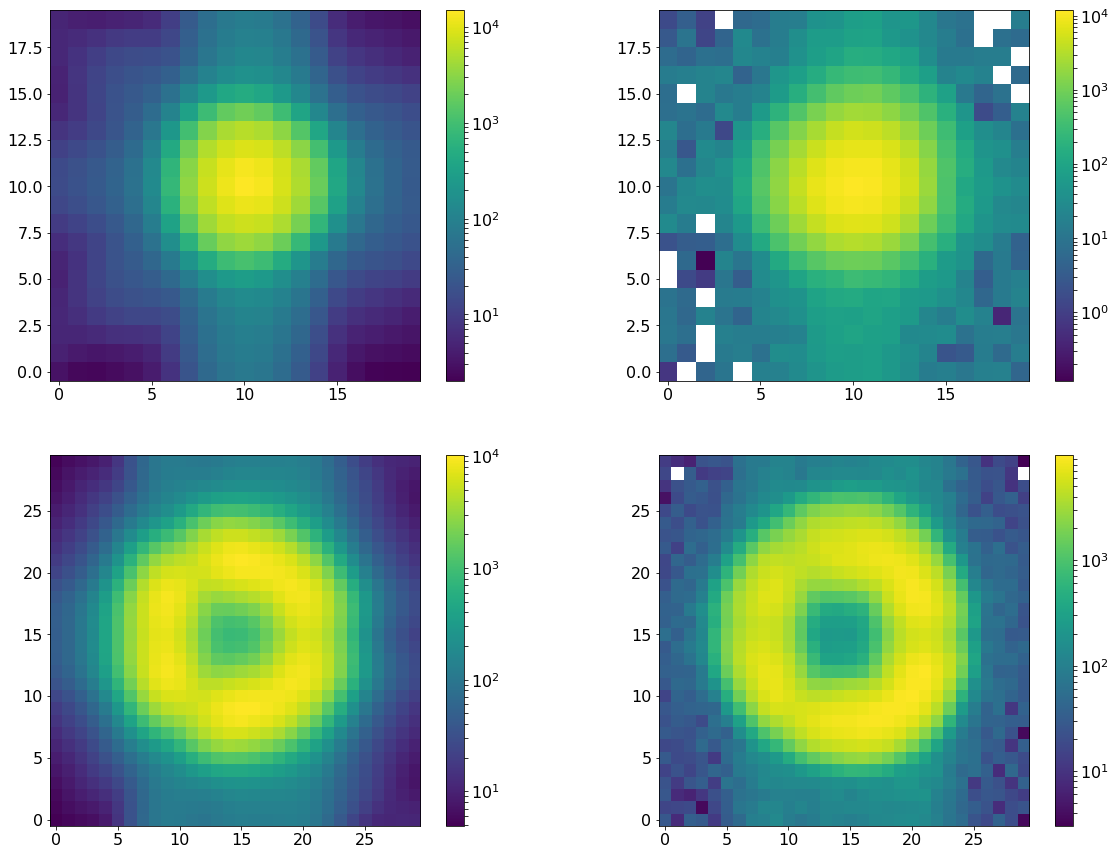

In [1424]:
plt.figure(figsize=(20,15))

plt.subplot(221)
plt.imshow(modelImgm05,origin='lower',norm=LogNorm())
plt.colorbar()

plt.subplot(222)
plt.imshow(sci_image_m05,origin='lower',norm=LogNorm())
plt.colorbar()

plt.subplot(223)
plt.imshow(modelImgp20,origin='lower',norm=LogNorm())
plt.colorbar()

plt.subplot(224)
plt.imshow(sci_image_p20,origin='lower',norm=LogNorm())
plt.colorbar()


## Scipt to submit jobs to cluster

In [1262]:
for obs in [8603]:
    for single_spot in [55]:
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/ManySpot'+str(single_spot)+'MayObs_P.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=8 # node count \n")
        file.write("#SBATCH --ntasks-per-node=40 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")

        file.write("mpirun python /home/ncaplar/Code/ZernikeManyDefocus_11_Mix_P.py "+str(obs)+" "+str(single_spot)+" 150 40\n")
        file.close()

In [1263]:
for obs in [8603]:
    for single_spot in [26]:
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/ManySpot'+str(single_spot)+'MayObs_P.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=8 # node count \n")
        file.write("#SBATCH --ntasks-per-node=40 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")

        file.write("mpirun python /home/ncaplar/Code/ZernikeManyDefocus_11_Mix_P.py "+str(obs)+" "+str(single_spot)+" 150 40\n")
        file.close()

In [1264]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/MayScriptToSubmitScriptsTigerCPU'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in [26,55]:
    file.write('sbatch /home/ncaplar/Scripts/ManySpot'+str(single_spot)+'MayObs_P.sh \n')
file.close()

## Analysis

In [1425]:
#name of the spot which we will analyze
xycoordinates=55
single_number= xycoordinates

list_of_p_obs=[8564,8567,8570,8573]

sci_image_p=[]
var_image_p=[]

for obs in list_of_p_obs:
    scidata=np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
    vardata=np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')
    sci_image_p.append(scidata)
    var_image_p.append(vardata)
    
    
list_of_m_obs=np.flip([8615,8612,8609,8606],axis=0)    

sci_image_m=[]
var_image_m=[]     
    
for obs in list_of_m_obs:
    scidata=np.load(DATA_FOLDER+'sci'+str(obs)+
                    str(single_number)+'Stacked.npy')
    vardata=np.load(DATA_FOLDER+'var'+str(obs)+
                    str(single_number)+'Stacked.npy')
    sci_image_m.append(scidata)
    var_image_m.append(vardata)   

list_of_0_obs=[8603]
sci_image_0=[]
var_image_0=[]   

    
for obs in list_of_0_obs:
    scidata=np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
    vardata=np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')
    sci_image_0.append(scidata)
    var_image_0.append(vardata)

sci_image=sci_image_p+sci_image_0+sci_image_m
var_image=var_image_p+var_image_0+var_image_m


NAME_OF_CHAIN='chainMay23_Many_11_P_'+str(obs)+str(xycoordinates)
NAME_OF_LIKELIHOOD_CHAIN='likechainMay23_Many_11_P_'+str(obs)+str(xycoordinates)

#NAME_OF_FLATCHAIN='flatchainMay23_11_P_'+str(obs)+str(xycoordinates)
#NAME_OF_LIKELIHOOD_FLATCHAIN='likeflatchainMay23_11_P_'+str(obs)+str(xycoordinates)
#NAME_OF_PROBABILITY_CHAIN='probchainmay22_13_P_'+str(obs)+str(xycoordinates)

# how many parallel processes to run - not used ?
nthreads=4
# number of steps each walkers will take 
nsteps = 2


# Telescope size
diam_sic=Exit_pupil_size(-693.5)
zmax=11

sci_image_p=sci_image[0:4]
sci_image_m=sci_image[5:9]

var_image_p=var_image[0:4]
var_image_m=var_image[5:9]

sci_image_m05=sci_image_m[0]
sci_image_m10=sci_image_m[1]
sci_image_m15=sci_image_m[2]
sci_image_m20=sci_image_m[3]

var_image_m05=var_image_m[0]
var_image_m10=var_image_m[1]
var_image_m15=var_image_m[2]
var_image_m20=var_image_m[3]

sci_image_p05=sci_image_p[3]
sci_image_p10=sci_image_p[2]
sci_image_p15=sci_image_p[1]
sci_image_p20=sci_image_p[0]

var_image_p05=var_image_p[3]
var_image_p10=var_image_p[2]
var_image_p15=var_image_p[1]
var_image_p20=var_image_p[0]


In [1427]:
columnsAB=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  

method='P'
# This is for May2 run
#chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/chainMay2_512_'+str(obs)+str(single_number)+'.npy')
#flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/flatchainMay2_512_'+str(obs)+str(single_number)+'.npy')
#likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/likechainMay2_512_'+str(obs)+str(single_number)+'.npy')

# This is for May3 run
chain_Emcee1=np.load(RESULT_FOLDER+'chainMay23_Many_11_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee1.npy')
likechain_Emcee1=np.load(RESULT_FOLDER+'likechainMay23_Many_11_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee1.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee1=likechain_Emcee1[0]
chain0_Emcee1=chain_Emcee1[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee1.shape


chain_Emcee2=np.load(RESULT_FOLDER+'chainMay23_Many_11_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechainMay23_Many_11_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee2.shape

chain_Emcee3=np.load(RESULT_FOLDER+'chainMay23_Many_11_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee3.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechainMay23_Many_11_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee3.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee3.shape

(310, 300, 31)

In [1429]:
# minimal value of absolute likelihood
np.min(np.abs(likechain0_Emcee3))

3731944.4543990269

In [1430]:
# see the best chain, in numpy and pandas form
minchain=chain0_Emcee3[np.abs(likechain0_Emcee3)==np.min(np.abs(likechain0_Emcee3))][0]
minchain31=minchain
print(minchain)
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:16]]),columns=columnsAB[0:16])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][16:31]]),columns=columnsAB[16:31])
print(dfglobal)

[ 2.15862634 -0.3477549  -0.00485855 -0.05019779 -0.05333286 -0.11112809
  0.01313502  0.09302874 -0.02470114 -0.06621224  0.0003888  -0.04485689
  0.00495844 -0.0759576   0.03354514 -0.21291169  0.72169264  0.05011766
 -0.08025901  0.03251688  0.03362888  0.06556655  0.660434    0.28825972
  0.01197392  0.09292947  0.99962919 -0.04736183  0.85499271  0.27370909
  0.98567807]
        z4a       z4b       z5a       z5b        z6       z6b       z7a  \
0  2.158626 -0.347755 -0.004859 -0.050198 -0.053333 -0.111128  0.013135   

        z7b       z8a       z8b       z9a       z9b      z10a      z10b  \
0  0.093029 -0.024701 -0.066212  0.000389 -0.044857  0.004958 -0.075958   

       z11a      z11b  
0  0.033545 -0.212912  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.721693   0.050118 -0.080259  0.032517  0.033629     0.065567   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.660434              0.28826  0.011974  0.0

In [1434]:
total_number_of_pixels_squared=[]
for i in sci_image_p:
    total_number_of_pixels_squared.append(i.shape[0]**2)
    
for i in sci_image_m:
    total_number_of_pixels_squared.append(i.shape[0]**2)
    
total_number_of_pixels_squared=np.sum(total_number_of_pixels_squared)

like_min=[]
for i in range(likechain0_Emcee1.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee1[:,i])))

for i in range(likechain0_Emcee2.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee2[:,i])))    

for i in range(likechain0_Emcee3.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee3[:,i]))  )  
    
like_min=(np.array(like_min)-np.log(2*np.pi*np.sum(map(np.sum,var_image_p)+map(np.sum,var_image_m))))*(2)/total_number_of_pixels_squared
print('minimal chi**2 is: '+str(np.min(like_min)))

minimal chi**2 is: 1477.40585316


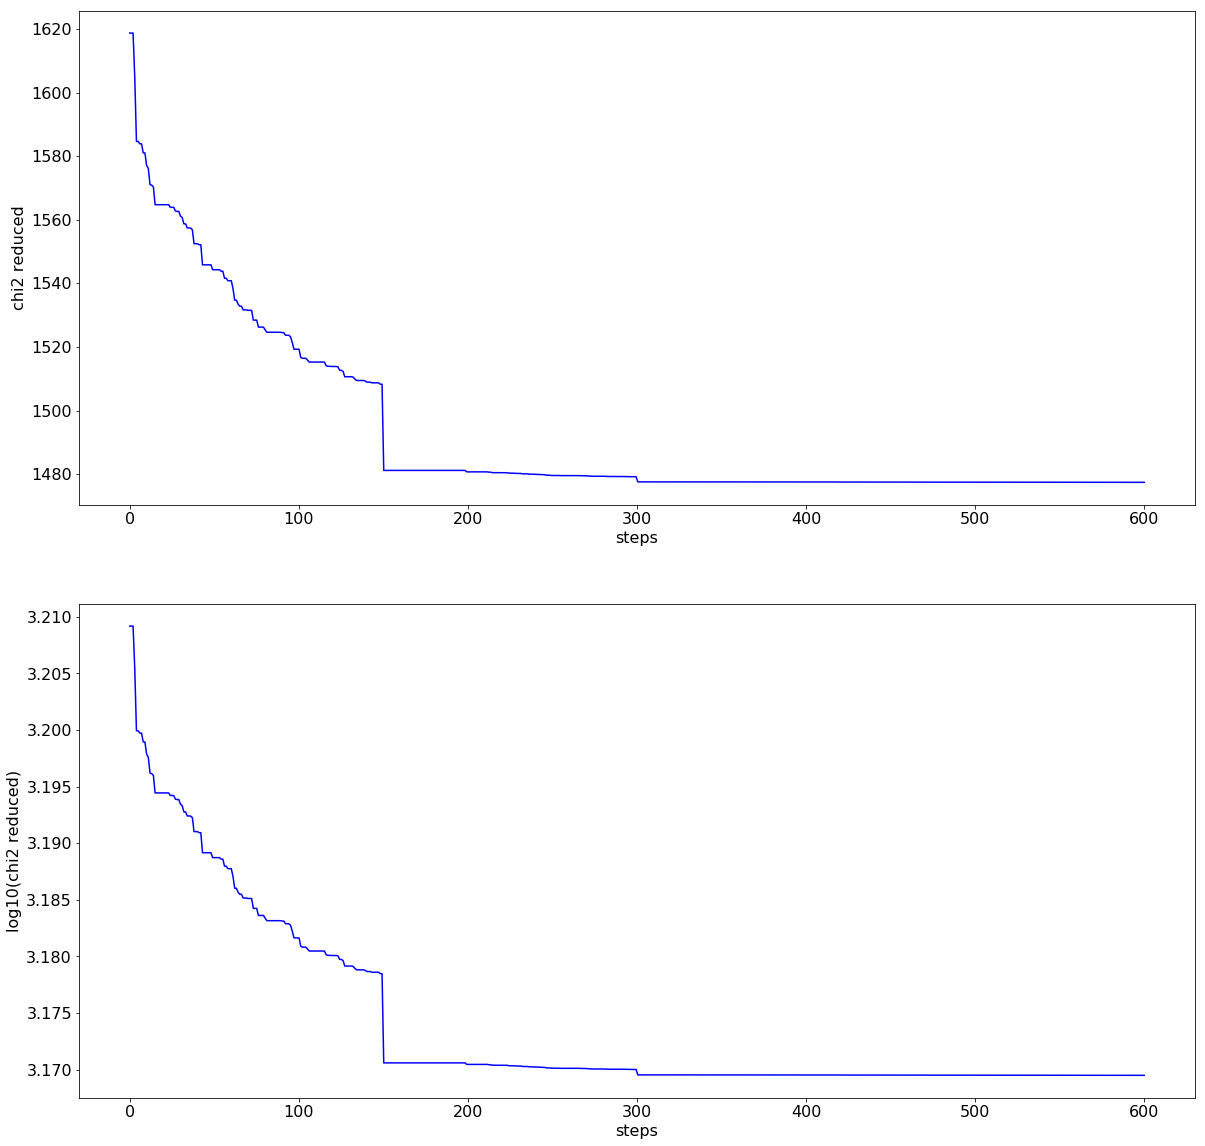

In [1435]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('chi2 reduced')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(chi2 reduced)')
plt.xlabel('steps')

In [1436]:
zparameters=minchain[0:16]
globalparameters=minchain[len(zparameters):len(zparameters)+15]

In [1437]:
single_image_analysis_p20=ZernikeFitter_PFS(sci_image_p20,var_image_p20)
single_image_analysis_p20.initParams(zmax) 
x=model.create_x(2,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p20.params[columns[i]].set(x[i])
modelImgp20 = single_image_analysis_p20.constructModelImage_PFS_naturalResolution(single_image_analysis_p20.params)
print('modelImgp20: '+str(np.sum((modelImgp20-sci_image_p20)**2/((var_image_p20.shape[0]*var_image_p20.shape[1])*var_image_p20))))
print(np.sum(np.abs((modelImgp20-sci_image_p20)))/np.sum((modelImgp20)))


single_image_analysis_p15=ZernikeFitter_PFS(sci_image_p15,var_image_p15)
single_image_analysis_p15.initParams(zmax) 
x=model.create_x(1.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p15.params[columns[i]].set(x[i])
modelImgp15 = single_image_analysis_p15.constructModelImage_PFS_naturalResolution(single_image_analysis_p15.params)
print('modelImgp15: '+str(np.sum((modelImgp15-sci_image_p15)**2/((var_image_p15.shape[0]*var_image_p15.shape[1])*var_image_p15))))
print(np.sum(np.abs((modelImgp15-sci_image_p15)))/np.sum((modelImgp15)))


single_image_analysis_p10=ZernikeFitter_PFS(sci_image_p10,var_image_p10)
single_image_analysis_p10.initParams(zmax) 
x=model.create_x(1,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p10.params[columns[i]].set(x[i])
modelImgp10 = single_image_analysis_p10.constructModelImage_PFS_naturalResolution(single_image_analysis_p10.params)
print('modelImgp15: '+str(np.sum((modelImgp10-sci_image_p10)**2/((var_image_p10.shape[0]*var_image_p10.shape[1])*var_image_p10))))
print(np.sum(np.abs((modelImgp10-sci_image_p10)))/np.sum((modelImgp10)))



single_image_analysis_p05=ZernikeFitter_PFS(sci_image_p05,var_image_p05)
single_image_analysis_p05.initParams(zmax) 
x=model.create_x(0.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_p05.params[columns[i]].set(x[i])
modelImgp05 = single_image_analysis_p05.constructModelImage_PFS_naturalResolution(single_image_analysis_p05.params)
print('modelImgp05: '+str(np.sum((modelImgp05-sci_image_p05)**2/((var_image_p05.shape[0]*var_image_p05.shape[1])*var_image_p05))))
print(np.sum(np.abs((modelImgp05-sci_image_p05)))/np.sum((modelImgp05)))



single_image_analysis_m20=ZernikeFitter_PFS(sci_image_m20,var_image_m20)
single_image_analysis_m20.initParams(zmax) 
x=model.create_x(-2,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m20.params[columns[i]].set(x[i])
modelImgm20 = single_image_analysis_m20.constructModelImage_PFS_naturalResolution(single_image_analysis_m20.params)
print('modelImgp20: '+str(np.sum((modelImgm20-sci_image_m20)**2/((var_image_m20.shape[0]*var_image_m20.shape[1])*var_image_m20))))
print(np.sum(np.abs((modelImgm20-sci_image_m20)))/np.sum((modelImgm20)))



single_image_analysis_m15=ZernikeFitter_PFS(sci_image_m15,var_image_m15)
single_image_analysis_m15.initParams(zmax) 
x=model.create_x(-1.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m15.params[columns[i]].set(x[i])
modelImgm15 = single_image_analysis_m15.constructModelImage_PFS_naturalResolution(single_image_analysis_m15.params)
print('modelImgp15: '+str(np.sum((modelImgm15-sci_image_m15)**2/((var_image_m15.shape[0]*var_image_m15.shape[1])*var_image_m15))))
print(np.sum(np.abs((modelImgm15-sci_image_m15)))/np.sum((modelImgm15)))



single_image_analysis_m10=ZernikeFitter_PFS(sci_image_m10,var_image_m10)
single_image_analysis_m10.initParams(zmax) 
x=model.create_x(-1,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m10.params[columns[i]].set(x[i])
modelImgm10 = single_image_analysis_m10.constructModelImage_PFS_naturalResolution(single_image_analysis_m10.params)
print('modelImgp10: '+str(np.sum((modelImgm10-sci_image_m10)**2/((var_image_m10.shape[0]*var_image_m10.shape[1])*var_image_m10))))
print(np.sum(np.abs((modelImgm10-sci_image_m10)))/np.sum((modelImgm10)))

single_image_analysis_m05=ZernikeFitter_PFS(sci_image_m05,var_image_m05)
single_image_analysis_m05.initParams(zmax) 
x=model.create_x(-0.5,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_m05.params[columns[i]].set(x[i])
modelImgm05 = single_image_analysis_m05.constructModelImage_PFS_naturalResolution(single_image_analysis_m05.params)
print('modelImgp05: '+str(np.sum((modelImgm05-sci_image_m05)**2/((var_image_m05.shape[0]*var_image_m05.shape[1])*var_image_m05))))
print(np.sum(np.abs((modelImgm05-sci_image_m05)))/np.sum((modelImgm05)))


modelImgp20: 27.2234456736
0.077894873409
modelImgp15: 26.0963318884
0.0685501576994
modelImgp15: 20.5395776891
0.06424375811
modelImgp05: 10.7884029745
0.0581678297359
modelImgp20: 39.2176563561
0.137957109799
modelImgp15: 17.5163444586
0.114984656219
modelImgp10: 7.51965387767
0.0738891105389
modelImgp05: 5.5622385148
0.0479714201308


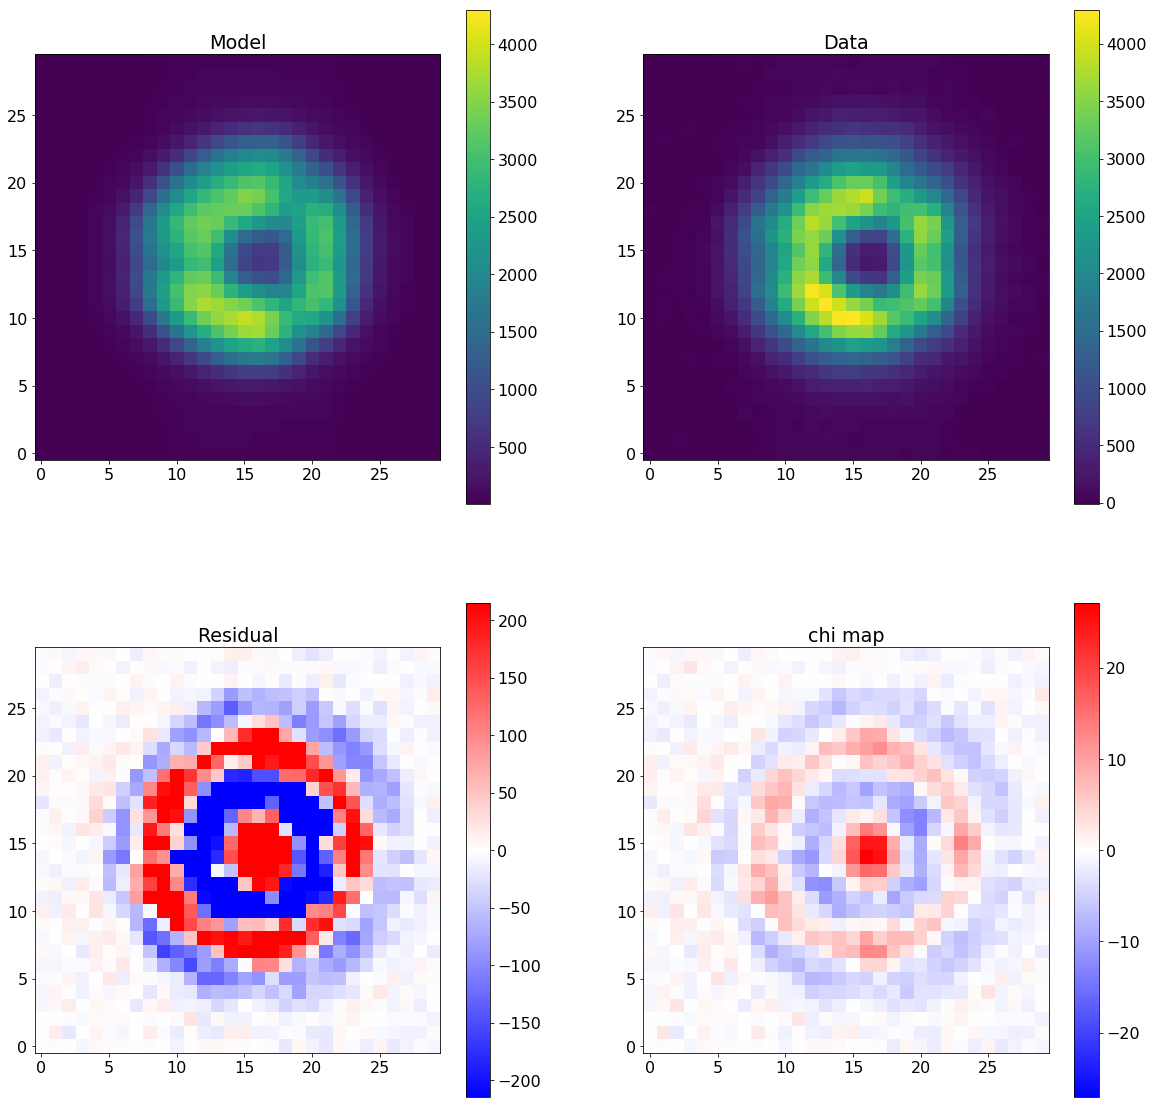

In [1438]:
# here you can select one of the generated images and look at it
which_image='m15'

if which_image=='m15':
    res_iapetus=modelImgm15
    inputimage=sci_image_m15
    var_inputimage=var_image_m15






plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-inputimage,origin='lower',cmap='bwr',vmin=-np.max(np.abs(inputimage))/20,vmax=np.max(np.abs(inputimage))/20)
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)/np.sqrt(var_inputimage),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))),vmin=-np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))))
plt.colorbar()
plt.title('chi map')

17.5163444586


0.1149846562193929

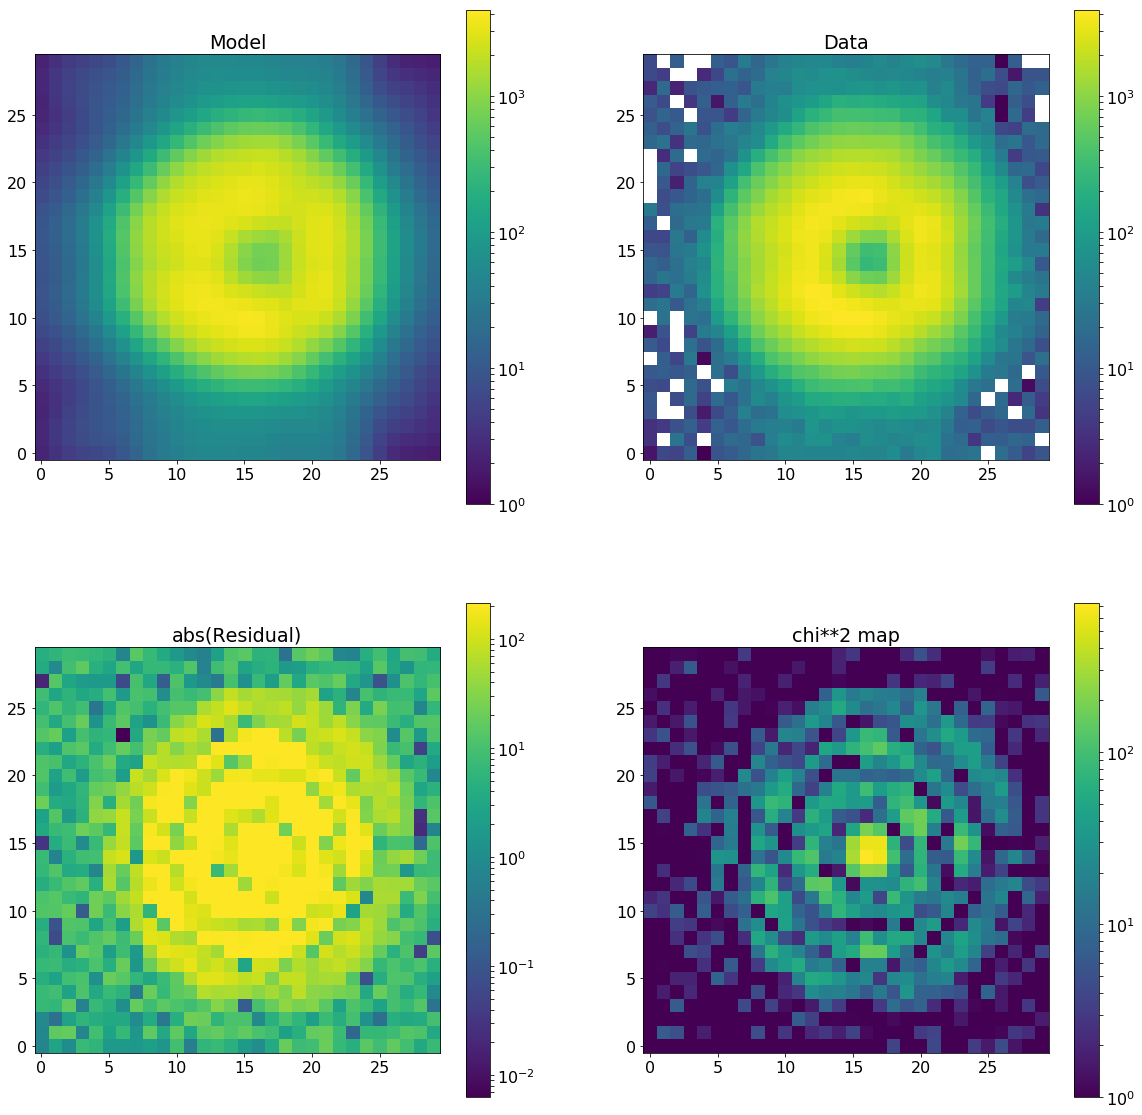

In [1439]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmin=1,vmax=np.max(np.abs(inputimage)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmin=1,vmax=np.max(np.abs(inputimage)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus-inputimage),origin='lower',vmax=np.max(np.abs(inputimage))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)**2/((1)*var_inputimage),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-inputimage)**2/((var_inputimage.shape[0]*var_inputimage.shape[1])*var_inputimage)))
np.sum(np.abs((res_iapetus-inputimage)))/np.sum((res_iapetus))

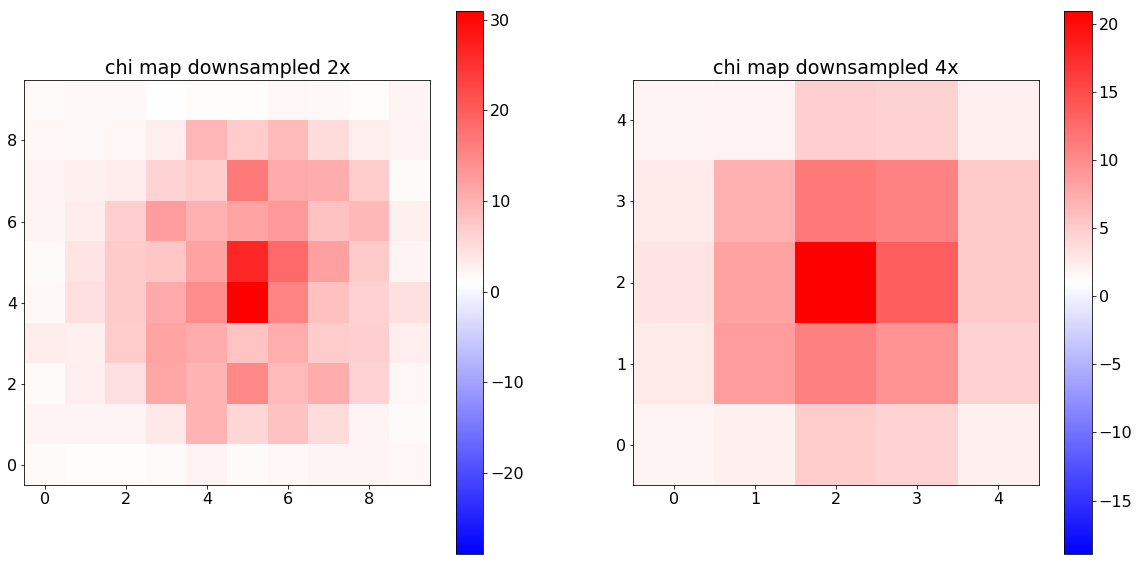

In [1440]:
chi_downsample_10=downsample_manual_function_abs((res_iapetus-inputimage)/np.sqrt(var_inputimage),10)/4
chi_downsample_5=downsample_manual_function_abs((res_iapetus-inputimage)/np.sqrt(var_inputimage),5)/16


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_10,origin='lower',cmap='bwr',vmin=1-(np.max(np.abs(chi_downsample_10))-1),vmax=np.max(np.abs(chi_downsample_10)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_5,origin='lower',cmap='bwr',vmin=1-(np.max(np.abs(chi_downsample_5))-1),vmax=np.max(np.abs(chi_downsample_5)))
plt.colorbar()
plt.title('chi map downsampled 4x')


In [1441]:
print('center of the model image is at: '+str(map(lambda x: x/len(res_iapetus), find_centroid_of_flux(res_iapetus))))
print('center of the input image is at: '+str(map(lambda x: x/len(inputimage), find_centroid_of_flux(inputimage))))
print('number of photons in the model image is: '+str(np.sum(res_iapetus)))
print('number of photons in the input image is: '+str(np.sum(inputimage)))

center of the model image is at: [0.50893184573395389, 0.48731568786798046]
center of the input image is at: [0.51092771957338778, 0.48696282767822641]
number of photons in the model image is: 598667.467064
number of photons in the input image is: 607366.0


## Prediction at 0

In [1442]:
# this code predicts the value of parameters at defocus 0
x=model.create_x(0,zparameters,globalparameters)
minchain=x
print(minchain)
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:16]]),columns=columns[0:16])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][16:31]]),columns=columns[16:31])
print(dfglobal)

[-0.3477549  -0.05019779 -0.11112809  0.09302874 -0.06621224 -0.04485689
 -0.0759576  -0.21291169  0.72169264  0.05011766 -0.08025901  0.03251688
  0.03362888  0.06556655  0.660434    0.28825972  0.01197392  0.09292947
  0.99962919 -0.04736183  0.85499271  0.27370909  0.98567807]
         z4        z5        z6        z7        z8        z9       z10  \
0 -0.347755 -0.050198 -0.111128  0.093029 -0.066212 -0.044857 -0.075958   

        z11   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0 -0.212912  0.721693   0.050118 -0.080259  0.032517  0.033629     0.065567   

   radiometricEffect  radiometricExponent  
0           0.660434              0.28826  
     x_ilum    y_ilum  minorAxis  pupilAngle   fiber_r  pixel_effect      flux
0  0.011974  0.092929   0.999629   -0.047362  0.854993      0.273709  0.985678


In [1444]:
single_image_analysis_0=ZernikeFitter_PFS(sci_image[4],var_image[4])
single_image_analysis_0.initParams(zmax) 
x=model.create_x(0,zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis_0.params[columns[i]].set(x[i])
modelImg_0 = single_image_analysis_0.constructModelImage_PFS_naturalResolution(single_image_analysis_0.params)
print('modelImg0: '+str(np.sum((modelImg_0-sci_image[4])**2/((var_image[4].shape[0]*var_image[4].shape[1])*var_image[4]))))
print(np.sum(np.abs((modelImg_0-sci_image[4])))/np.sum((modelImg_0)))

modelImg0: 23.2872644054
0.0905318687438


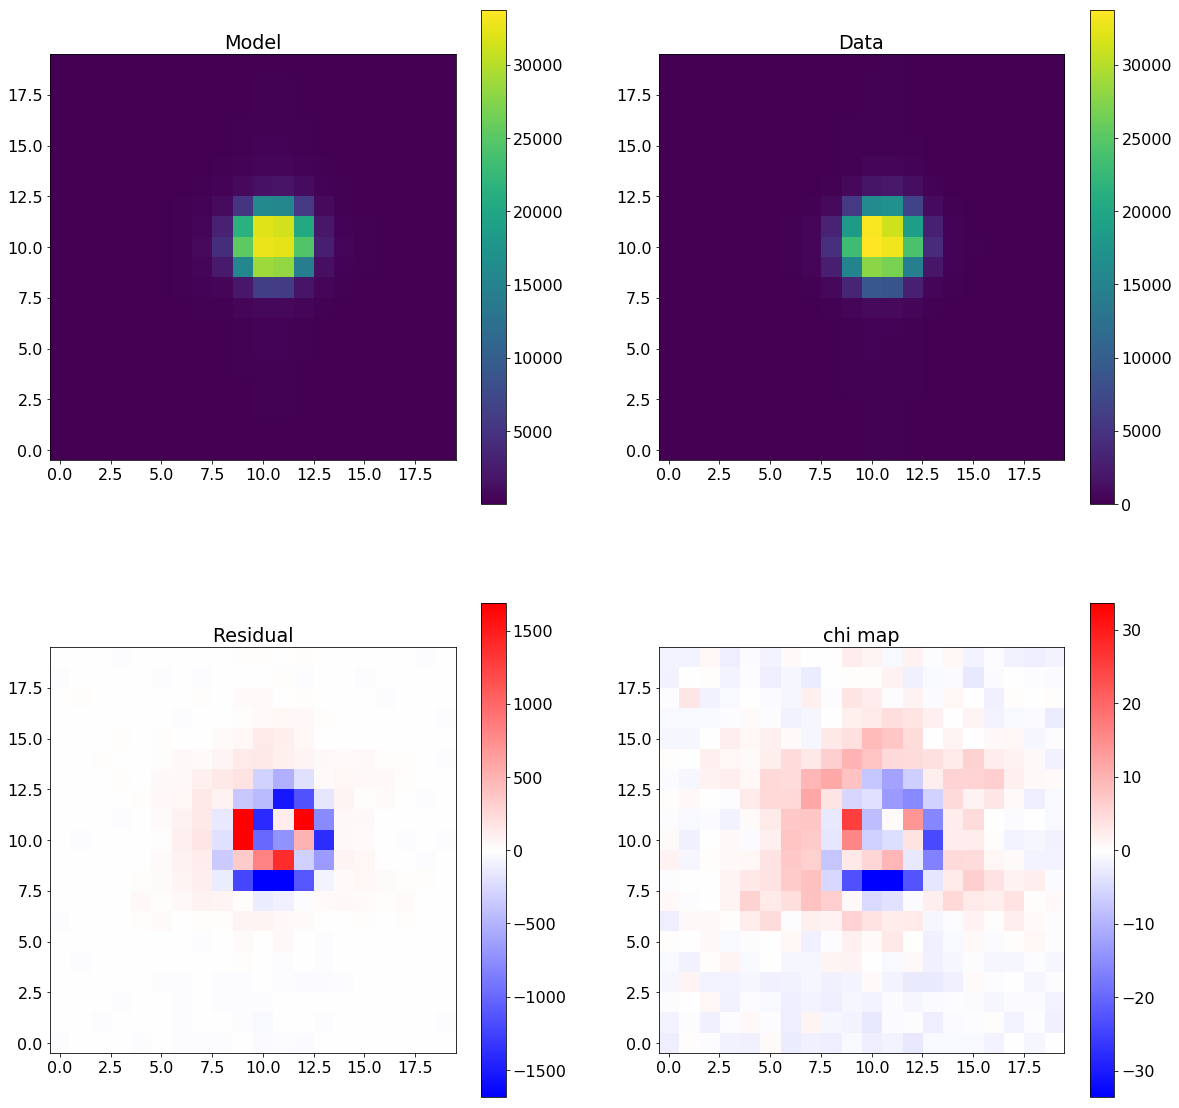

In [1445]:
which_image='0'

if which_image=='0':
    res_iapetus=modelImg_0
    inputimage=sci_image[4]
    var_inputimage=var_image[4]

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-inputimage,origin='lower',cmap='bwr',vmin=-np.max(np.abs(inputimage))/20,vmax=np.max(np.abs(inputimage))/20)
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)/np.sqrt(var_inputimage),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))),vmin=-np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))))
plt.colorbar()
plt.title('chi map')

23.2872644054


0.090531868743771046

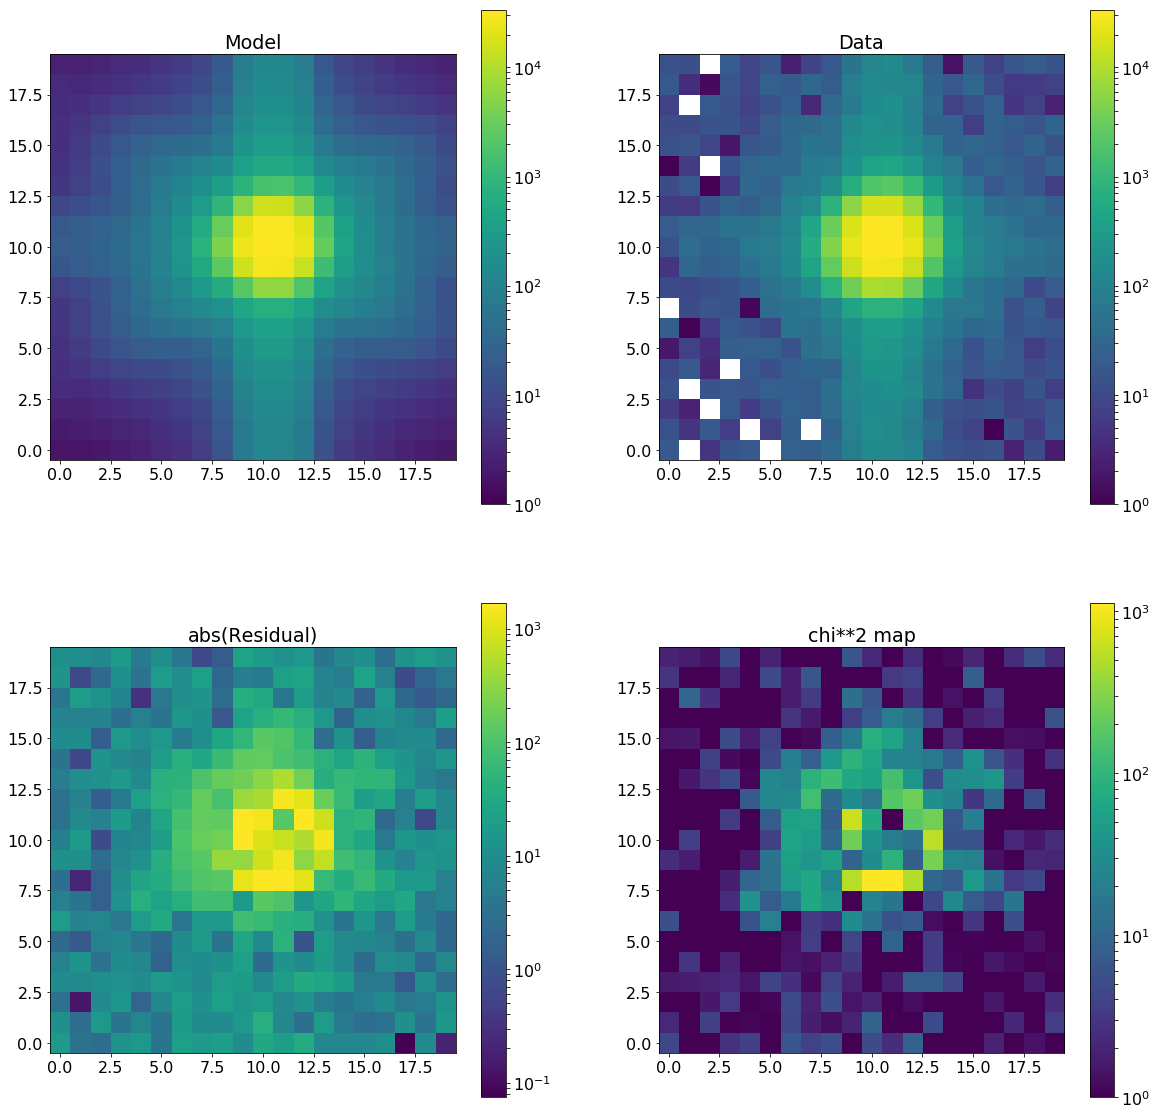

In [1367]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmin=1,vmax=np.max(np.abs(inputimage)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmin=1,vmax=np.max(np.abs(inputimage)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus-inputimage),origin='lower',vmax=np.max(np.abs(inputimage))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)**2/((1)*var_inputimage),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-inputimage)**2/((var_inputimage.shape[0]*var_inputimage.shape[1])*var_inputimage)))
np.sum(np.abs((res_iapetus-inputimage)))/np.sum((res_iapetus))

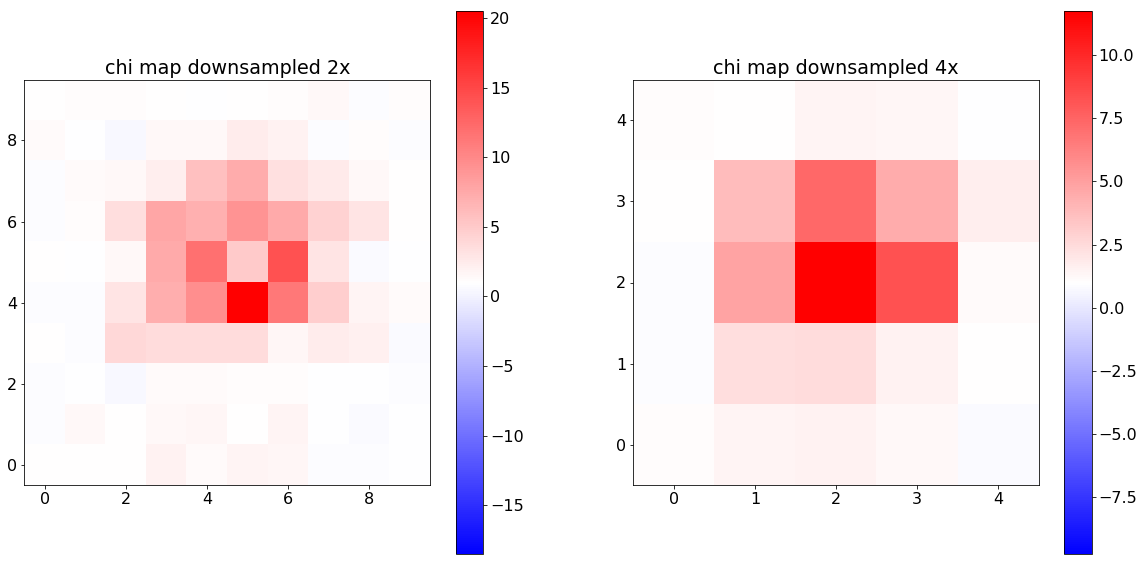

In [1368]:
chi_downsample_10=downsample_manual_function_abs((res_iapetus-inputimage)/np.sqrt(var_inputimage),10)/4
chi_downsample_5=downsample_manual_function_abs((res_iapetus-inputimage)/np.sqrt(var_inputimage),5)/16


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_10,origin='lower',cmap='bwr',vmin=1-(np.max(np.abs(chi_downsample_10))-1),vmax=np.max(np.abs(chi_downsample_10)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_5,origin='lower',cmap='bwr',vmin=1-(np.max(np.abs(chi_downsample_5))-1),vmax=np.max(np.abs(chi_downsample_5)))
plt.colorbar()
plt.title('chi map downsampled 4x')


In [1369]:
print('center of the model image is at: '+str(map(lambda x: x/len(res_iapetus), find_centroid_of_flux(res_iapetus))))
print('center of the input image is at: '+str(map(lambda x: x/len(inputimage), find_centroid_of_flux(inputimage))))
print('number of photons in the model image is: '+str(np.sum(res_iapetus)))
print('number of photons in the input image is: '+str(np.sum(inputimage)))

center of the model image is at: [0.52211963163330055, 0.51033793257747806]
center of the input image is at: [0.52414692341181379, 0.50785847704514986]
number of photons in the model image is: 416713.729589
number of photons in the input image is: 422769.0


### corner 

In [1375]:
minchain

array([-0.3477549 , -0.05019779, -0.11112809,  0.09302874, -0.06621224,
       -0.04485689, -0.0759576 , -0.21291169,  0.72169264,  0.05011766,
       -0.08025901,  0.03251688,  0.03362888,  0.06556655,  0.660434  ,
        0.28825972,  0.01197392,  0.09292947,  0.99962919, -0.04736183,
        0.85499271,  0.27370909,  0.98567807])

In [1379]:
%%capture
import corner

matplotlib.rcParams.update({'font.size': 16})
flatchain0=np.reshape(chain0_Emcee3,(chain0_Emcee3.shape[0]*chain0_Emcee3.shape[1],chain0_Emcee3.shape[2]))

figure=corner.corner(flatchain0[:,0:16], labels=columnsAB[0:16],
                  truths=list(minchain31[0:16]))
figure.savefig(IMAGES_FOLDER+'zparameters.png')

In [1380]:
%%capture
matplotlib.rcParams.update({'font.size': 16})
flatchain0=np.reshape(chain0_Emcee3,(chain0_Emcee3.shape[0]*chain0_Emcee3.shape[1],chain0_Emcee3.shape[2]))

figure=corner.corner(flatchain0[:,16:31], labels=columnsAB[16:31],
                  truths=list(minchain31[16:31]))
figure.savefig(IMAGES_FOLDER+'/globalparameters.png')

# Analysis of a single image 

In [1381]:
#init class
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,wavelength=None,
                 jacobian=None,diam_sic=None,npix=None,pupilExplicit=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds 
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        @param wavelength   wavelenght      
        @param npix         number of pixels describign the pupil
        @param illumminatedFrac ?
        @param pupilExplicit if you want to pass explicit image of the exit pupil
        """
        

        
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
            
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var

        #flux has to be declared after image 
        flux = float(np.sum(image))
        self.flux=flux    
            
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            self.jacobian = jacobian
        
        if wavelength is None:
            wavelength=794
            self.wavelength=wavelength
        else:
            self.wavelength=wavelength       
        
        # This is scale for PFS red arm in focus
        if pixelScale is None:
            pixelScale=20.598753429811214
            self.pixelScale=pixelScale
        else:
            self.pixelScale=pixelScale
        
        # Exit pupil size in focus
        if diam_sic is None:
            diam_sic=136.93774e-3
            self.diam_sic=diam_sic
        else:
            self.diam_sic=diam_sic
        
        if npix is None:
            npix=594
            self.npix=npix
        else:
            self.npix=npix   
            
        if pupilExplicit is None:
            pupilExplicit==False
            self.pupilExplicit=pupilExplicit
        else:
            self.pupilExplicit=pupilExplicit
                     
        self.kwargs = kwargs
    
    def initParams(self, zmax=11, z4Init=None, dxInit=None,dyInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,fiber_rInit=None,
                  slitFracInit=None,slitFrac_dy_Init=None,apodizationInit=None,radiometricEffectInit=None,
                   trace_valueInit=None,serial_trace_valueInit=None,pixel_effectInit=None,backgroundInit=None,fluxInit=None,
                   x_ilumInit=None,y_ilumInit=None,radiometricExponentInit=None,minorAxisInit=None,pupilAngleInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves (that is 2*np.pi*wavelengths).
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscured by the central obscuration(camera) 
        @param strutFracInit        Fraction of the pupil obscured by a single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Diameters of the telescope in meters
        @param fiber_rInit          Multiplicative factor that determines the size of the input fiber
        @param trace_valueInit      Which fraction of the flux spot goes in the trace
        """

        self.zmax=zmax
        params = lmfit.Parameters()

        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if dxInit is None:
            params.add('dx', 0.0)
        else:
            params.add('dx', dxInit)

        if dyInit is None:
            params.add('dy', 0.0)
        else:
            params.add('dy', dyInit)   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1])  
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
    
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        if slitFrac_dy_Init is None:
            params.add('slitFrac_dy', 0)
        else:
            params.add('slitFrac_dy', slitFrac_dy_Init)   
            
        if apodizationInit is None:
            params.add('apodization', 10)
        else:
            params.add('apodization', apodizationInit)  
            
        if radiometricEffectInit is None:
            params.add('radiometricEffect', 0)
        else:
            params.add('radiometricEffect', radiometricEffectInit)    
            
        if trace_valueInit is None:
            params.add('trace_value', 0)
        else:
            params.add('trace_value', trace_valueInit)  
            
        if serial_trace_valueInit is None:
            params.add('serial_trace_value', 0)
        else:
            params.add('serial_trace_value', serial_trace_valueInit)  
            
        if pixel_effectInit is None:
            params.add('pixel_effect', 1)
        else:
            params.add('pixel_effect', pixel_effectInit)       
            
        if backgroundInit is None:
            params.add('background', 0)
        else:
            params.add('background', backgroundInit)    
            
        if fluxInit is None:
            params.add('flux', 1)
        else:
            params.add('flux', fluxInit)                

        if x_ilumInit is None:
            params.add('x_ilum', 0)
        else:
            params.add('x_ilum', x_ilumInit)   
            
        if y_ilumInit is None:
            params.add('y_ilum', 0)
        else:
            params.add('y_ilum', y_ilumInit)   

        if radiometricExponentInit is None:
            params.add('radiometricExponent', 0.25)
        else:
            params.add('radiometricExponent', radiometricExponentInit)  
            
        if minorAxisInit is None:
            params.add('minorAxis', 1)
        else:
            params.add('minorAxis', minorAxisInit)   

        if pupilAngleInit is None:
            params.add('pupilAngle', 0)
        else:
            params.add('pupilAngle', pupilAngleInit)          
            
        nyquistscale=nyQuistScale(self.diam_sic,self.wavelength,self.npix)
        self.nyquistscale=nyquistscale
        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix
        illumminatedFrac=self.illumminatedFrac     
        
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
            
        Pupil_Image=PFSPupilFactory(diam_sic,npix,
                                    np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['slitFrac'.format(i)],
                                    params['slitFrac_dy'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
        
        # relic code if you want to see how the pupil looks
        #np.save('/Users/nevencaplar/Documents/PFS/FromZemax/pupil',pupil.illuminated.astype(np.int16))    
     
        #pupilW=np.load('/Users/nevencaplar/Documents/PFS/FromZemax/resZemaxNormalizedAll5.npy')
        #pupilW=np.transpose(pupilW)
        #aper = galsim.Aperture(
        #    diam = pupil.size,
        #    pupil_plane_im = pupil.illuminated.astype(np.int16),
        #    pupil_plane_scale = pupil.scale,
        #    pupil_plane_size = None)  
        
        # this code allows the user the specify the exact pupil 
        if self.pupilExplicit is None:
            aper = galsim.Aperture(
                diam = pupil.size,
                pupil_plane_im = pupil.illuminated.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None) 
        else:
            aper = galsim.Aperture(
                diam =  pupil.size,
                pupil_plane_im = self.pupilExplicit.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None)                 
            
        # pad_factor=2.0,oversampling=2 do nothing here as we are providing the pupil already
        big_fft_params = galsim.GSParams(maximum_fft_size=18240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=2.0,oversampling=2)

    def _getOptPsf_naturalResolution(self,params):
        "returns array in natural resolution"
        aberrations_init=[0.0,0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix   

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
            
        Pupil_Image=PFSPupilFactory(diam_sic,npix,
                                    np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],params['slitFrac'.format(i)],
                                    params['slitFrac_dy'.format(i)],params['minorAxis'.format(i)],params['pupilAngle'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
        
        if self.pupilExplicit is None:
            aper = galsim.Aperture(
                diam = pupil.size,
                pupil_plane_im = pupil.illuminated.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None) 
        else:
            aper = galsim.Aperture(
                diam =  pupil.size,
                pupil_plane_im = self.pupilExplicit.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None)   
            
        optics_screen = galsim.OpticalScreen(diam=diam_sic,aberrations=aberrations,lam_0=self.wavelength)
        screens = galsim.PhaseScreenList(optics_screen)    
        
        ilum=np.array(aper.illuminated, dtype=np.float64)

        points = np.linspace(-2, 2,num=ilum.shape[0])
        xs, ys = np.meshgrid(points, points)
        r = np.sqrt((xs-params['x_ilum'])** 2 + (ys-params['y_ilum'])** 2)
        radiometricEffectArray=(1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
        ilum_radiometric=np.nan_to_num(radiometricEffectArray*ilum,0) 
     
        # this is where apodization happens
        r = gaussian_filter(ilum_radiometric, sigma=params['apodization'.format(i)])
          
        #resizing is here 
        r=skimage.transform.resize(r,(npix*2,npix*2),order=3)
        
        r_ilum_pre=np.copy(r)
        r_ilum_pre[r>0.01]=1
        r_ilum_pre[r<0.01]=0
        r_ilum=r_ilum_pre.astype(bool)

        # manual creation of aper.u and aper.v
        aperu_manual=[]
        for i in range(2*npix):
            aperu_manual.append(np.linspace(-diam_sic,diam_sic,2*npix, endpoint=True))

        u_manual=np.array(aperu_manual)
        v_manual=np.transpose(aperu_manual)        
        
        u=u_manual[r_ilum]
        v=v_manual[r_ilum]

        #u = aper.u[r_ilum]
        #v = aper.v[r_ilum]

        wf = screens.wavefront(u, v, None, 0)
        wf_grid = np.zeros_like(r_ilum, dtype=np.float64)
        wf_grid[r_ilum] = (wf/self.wavelength)

        wf_grid_rot=wf_grid

        expwf_grid = np.zeros_like(r_ilum, dtype=np.complex128)
        expwf_grid[r_ilum] = r[r_ilum]*np.exp(2j*np.pi * wf_grid_rot[r_ilum])

        ftexpwf = galsim.fft.fft2(expwf_grid,shift_in=True,shift_out=True)
        img_apod = np.abs(ftexpwf)**2
        return img_apod
    
    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            jacobian = self.jacobian    
            
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        optPsf = optPsf.shift(pixelScale*v['dx'], pixelScale*v['dy'])
        #print(optPsf)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))

        # fiber smearing here
        fiber = galsim.TopHat(flux=1, radius=pixelScale*1/2*v['fiber_r'])
        optPsfConvolvedwithFiber= galsim.Convolve([optPsf,fiber])

        # create image
        modelImg = optPsfConvolvedwithFiber.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
        
        # adding trace
        print(modelImg)
        return_img_before_trace=modelImg.array
        return_img_after_trace=self.create_trace(return_img_before_trace,v['trace_value'])

        # normalizing flux in the image
        multiplicative_factor=np.sum(self.image)/np.sum(return_img_after_trace)
        finalImg=multiplicative_factor*return_img_after_trace
        
        return finalImg

    def constructModelImage_PFS_naturalResolution(self,params=None,shape=None,pixelScale=None,jacobian=None):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            jacobian = self.jacobian    
            
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params
        
        # This give image in nyquist resolution
        optPsf=self._getOptPsf_naturalResolution(v)
        
        # what is nyquistscale scale
        nyquistscale=self.nyquistscale
        # how much is my generated image oversampled
        oversampling=self.pixelScale/nyquistscale
        # how big does the image have to be 
        #SizeOfImageBeforeResizing=int(round(self.pixelScale/nyquistscale*len(self.image))) 
        
        # this code below for automatic finding of centroid      
        #centroid_of_sci_image=map(lambda x: x/len(self.image), find_centroid_of_flux(self.image))   
        
        # fiber smearing here       
        # create fiber kernel
        #print(oversampling)
        #print(v['fiber_r'])
        #print(int(oversampling*2*v['fiber_r']))

        #print(v['fiber_r'])
        #print(v)
        fiber = astropy.convolution.Tophat2DKernel(int(oversampling*2*v['fiber_r'])).array

        # fiber convolved to accomodate possible numerical aperature effects
        #if v['fiber_NA_effect']==0:
        #    fiber_convolved=fiber
        #else:
        #    fiber_convolved=scipy.signal.fftconvolve(fiber, Gaussian2DKernel(oversampling*2*v['fiber_r']*v['fiber_NA_effect']).array, mode = 'full')  
            
        # convolve with fiber
        optPsf_fiber_convolved=scipy.signal.fftconvolve(optPsf, fiber, mode = 'same') 
        
        #cut part which you need
        #optPsf_cut_fiber_convolved_cut=cut_Centroid_of_natural_resolution_image(optPsf_cut_fiber_convolved,SizeOfImageBeforeResizing,oversampling,v['dx'],v['dy'])
        optPsf_cut_fiber_convolved=cut_Centroid_of_natural_resolution_image(optPsf_fiber_convolved,len(optPsf_fiber_convolved)/2,1,0,0)
            
            
        #pixels are not perfect, sigma is around 7 microns Jim clames
        optPsf_cut_pixel_response_convolved=scipy.signal.fftconvolve(optPsf_cut_fiber_convolved, Gaussian2DKernel(oversampling*v['pixel_effect']).array, mode = 'same')
        
        #manual with automatic find of best dx and dy
        optPsf_cut_fiber_convolved_downsampled=find_single_realization_min_cut(optPsf_cut_pixel_response_convolved,
                                                                               int(oversampling),shape[0],self.image,self.image_var,
                                                                               v['flux'])
        
        
        return optPsf_cut_fiber_convolved_downsampled
    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       residual 
        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

class LN_PFS_single(object):
        
    def __init__(self,sci_image,var_image):    
                
        #print("Checkpoint 1")      
        
        DATA_FOLDER='/tigress/ncaplar/Data/JanData/'
        self.DATA_FOLDER=DATA_FOLDER
        RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/Results/'
        self.RESULT_FOLDER=RESULT_FOLDER
        NAME_OF_CHAIN='NAME_OF_CHAIN'
        self.NAME_OF_CHAIN=NAME_OF_CHAIN
        
        self.columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']         

        #self.columns=['z4','z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
        #         'hscFrac','strutFrac','dxFocal','dyFocal','fiber_r','fiber_NA_effect','slitFrac','slitFrac_dy','trace_value']
        
        self.sci_image=sci_image
        self.var_image=var_image
        zmax=11
        
        single_image_analysis=ZernikeFitter_PFS(sci_image,var_image)
        single_image_analysis.initParams(zmax) 
        self.single_image_analysis=single_image_analysis

    def create_chi_2_almost(self,modelImg,sci_image,var_image):
       
        # this creates most normal chi2
        sigma = np.sqrt(var_image)
        chi = (sci_image - modelImg)/sigma
        chi2_intrinsic=np.sum(sci_image**2/var_image)
        
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        res=(chi_without_nan)**2
        
        # calculates q vaues
        Qlist=np.abs((sci_image - modelImg))
        Qlist_without_nan=Qlist.ravel()[~np.isnan(Qlist.ravel())]
        sci_image_without_nan=sci_image.ravel()[~np.isnan(sci_image.ravel())]
        Qvalue = np.sum(Qlist_without_nan)/np.sum(sci_image_without_nan)
        
        return [np.sum(res),chi2_intrinsic,Qvalue]
    
    def lnlike_Neven(self,allparameters):
        
        # this is now optimized to go to z22
        #print(len(allparameters))
        zparameters=allparameters[0:8]
        globalparameters=allparameters[8:(8+15)]

         # hsc frac
        if globalparameters[0]<=0.5:
            return -np.inf
        if globalparameters[0]>1.2:
            return -np.inf
        
         #strut frac
        if globalparameters[1]<0.05:
            return -np.inf
        if globalparameters[1]>0.2:
            return -np.inf
        
        #strut frac < slit_frac
        if globalparameters[1]<globalparameters[4]:
            return -np.inf
        
         #dx Focal
        if globalparameters[2]>0.8:
            return -np.inf
        if globalparameters[2]<-0.8:
            return -np.inf
        
        # dy Focal
        if globalparameters[3]>0.8:
            return -np.inf
        if globalparameters[3]<-0.8:
            return -np.inf
        
        # slitFrac
        if globalparameters[4]<0:
            return -np.inf
        if globalparameters[4]>0.2:
            return -np.inf
       
        # slitFrac_dy
        if globalparameters[5]<-0.5:
            return -np.inf
        if globalparameters[5]>0.5:
            return -np.inf
        
        # radiometricEffect
        if globalparameters[6]<0:
            return -np.inf
        if globalparameters[6]>3:
            return -np.inf  
        
        # radiometricExponent
        if globalparameters[7]<-0.5:
            return -np.inf
        if globalparameters[7]>5:
            return -np.inf 
        
        # x_ilum
        if globalparameters[8]<-0.8:
            return -np.inf
        if globalparameters[8]>0.8:
            return -np.inf
        
        # y_ilum
        if globalparameters[9]<-0.8:
            return -np.inf
        if globalparameters[9]>0.8:
            return -np.inf   
        
        # minorAxis
        if globalparameters[10]<0.8:
            return -np.inf
        if globalparameters[10]>1.0:
            return -np.inf      
        
        # pupilAngle
        if globalparameters[11]<-np.pi/2:
            return -np.inf
        if globalparameters[11]>np.pi/2:
            return -np.inf        
        
        # fiber_r
        if globalparameters[12]<0.2:
            return -np.inf
        if globalparameters[12]>+1.5:
            return -np.inf  
        
        # pixel_effect
        if globalparameters[13]<0.2:
            return -np.inf
        if globalparameters[13]>+1.1:
            return -np.inf  
        
        # flux
        if globalparameters[14]<0.8:
            return -np.inf
        if globalparameters[14]>1.2:
            return -np.inf      
        
        x=self.create_x(zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis.params[self.columns[i]].set(x[i])
        modelImg = self.single_image_analysis.constructModelImage_PFS_naturalResolution(self.single_image_analysis.params)  
        
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'x',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImg',modelImg)            
        #np.save(self.RESULT_FOLDER+self.NAME_OF_CHAIN+'zparameters',zparameters)
        #np.save(self.RESULT_FOLDER+self.NAME_OF_CHAIN+'globalparameters',globalparameters)       
        #np.save(self.RESULT_FOLDER+'modelImg',modelImg)

        chi_2_almost_multi_values=self.create_chi_2_almost(modelImg,self.sci_image,self.var_image)
        chi_2_almost=chi_2_almost_multi_values[0]
        chi_2_max=chi_2_almost_multi_values[1]     
        chi_2_Q=chi_2_almost_multi_values[2]


        chi_2_almost_reduced=chi_2_almost/(self.sci_image.shape[0]**2)
        #print(chi_2_almost)
        #print(chi_2_almost_reduced)
        #print(chi_2_Q)

        res=-(1/2)*(chi_2_almost+np.log(2*np.pi*np.sum(self.var_image)))
        return res

    def create_x(self,zparameters,globalparameters):
        #for single case, up to z22
        x=np.zeros((8+15))
        for i in range(len(zparameters)):
            x[i]=zparameters[i]     

        x[int(len(zparameters)/1)]=globalparameters[0] 

        #strutFrac
        x[int(len(zparameters)/1)+1]=globalparameters[1] 

        #dxFocal
        x[int(len(zparameters)/1)+2]=globalparameters[2] 

        #dyFocal
        x[int(len(zparameters)/1)+3]=globalparameters[3] 

        #slitFrac
        x[int(len(zparameters)/1)+4]=globalparameters[4]

        #slitFrac_dy
        x[int(len(zparameters)/1)+5]=globalparameters[5]  

        #radiometricEffect
        x[int(len(zparameters)/1)+6]=globalparameters[6]  

        #radiometricExponent
        x[int(len(zparameters)/1)+7]=globalparameters[7]  

        #x_ilum
        x[int(len(zparameters)/1)+8]=globalparameters[8] 
        
        #y_ilum
        x[int(len(zparameters)/1)+9]=globalparameters[9]  
        
        #minorAxis
        x[int(len(zparameters)/1)+10]=globalparameters[10]  

        #pupilAngle
        x[int(len(zparameters)/1)+11]=globalparameters[11] 
        
        #fiber_r
        x[int(len(zparameters)/1)+12]=globalparameters[12] 
        
        #pixel_effect
        x[int(len(zparameters)/1)+13]=globalparameters[13] 
        
        #flux
        x[int(len(zparameters)/1)+14]=globalparameters[14] 
        return x
     
    def __call__(self, allparameters):
        return self.lnlike_Neven(allparameters)

class LNP_PFS(object):
        
    def __call__(self, allparameters):
        return 0.0
    
#free definitions below
def create_parInit(allparameters_proposal=None):
    #if zmax=11
    number_of_par=8+15
    walkers_mult=10
    nwalkers=number_of_par*walkers_mult
    
    zparameters_flatten=allparameters_proposal[0:8]
    globalparameters_flatten=allparameters_proposal[8:(8+15)]
    #print(globalparameters_flatten)
    #print(globalparameters_flatten[0])
    try: 
        for i in range(8):
            if i==0:
                # larger search for defocus
               zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],1,nwalkers-1)))
            else:
                zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],0.25,nwalkers-1)))
            if i==0:
                zparameters_flat=zparameters_flat_single_par
            else:
                zparameters_flat=np.column_stack((zparameters_flat,zparameters_flat_single_par))
    except NameError:
        print('NameError!')
        
        
    #print(zparameters_flat.shape)       
    
    try:
        # hscFrac always positive
        globalparameters_flat_0=np.abs(np.random.normal(globalparameters_flatten[0],0.1,nwalkers*20))
        globalparameters_flat_0=np.concatenate(([globalparameters_flatten[0]],
                                                globalparameters_flat_0[np.all((globalparameters_flat_0>0.5,globalparameters_flat_0<1.2),axis=0)][0:nwalkers-1]))
        # strutFrac always positive
        globalparameters_flat_1_long=np.abs(np.random.normal(globalparameters_flatten[1],0.1,nwalkers*200))
        globalparameters_flat_1=globalparameters_flat_1_long
        globalparameters_flat_1=np.concatenate(([globalparameters_flatten[1]],
                                                globalparameters_flat_1[np.all((globalparameters_flat_1>0.05,globalparameters_flat_1<0.2),axis=0)][0:nwalkers-1]))
        # dxFocal
        globalparameters_flat_2=np.random.normal(globalparameters_flatten[2],0.1,nwalkers*20)
        globalparameters_flat_2=np.concatenate(([globalparameters_flatten[2]],
                                                globalparameters_flat_2[np.all((globalparameters_flat_2>-0.8,globalparameters_flat_2<0.8),axis=0)][0:nwalkers-1]))
        # dyFocal
        globalparameters_flat_3=np.random.normal(globalparameters_flatten[3],0.1,nwalkers*20)
        globalparameters_flat_3=np.concatenate(([globalparameters_flatten[3]],
                                                globalparameters_flat_3[np.all((globalparameters_flat_3>-0.8,globalparameters_flat_3<0.8),axis=0)][0:nwalkers-1]))
        # slitFrac
        globalparameters_flat_4=np.abs(np.random.normal(globalparameters_flatten[4],0.05,nwalkers*20))
        globalparameters_flat_4=np.concatenate(([globalparameters_flatten[4]],
                                                globalparameters_flat_4[np.all((globalparameters_flat_4>0.0,globalparameters_flat_4<0.2),axis=0)][0:nwalkers-1]))
        # slitFrac_dy
        globalparameters_flat_5=np.abs(np.random.normal(globalparameters_flatten[5],0.1,nwalkers*20))      
        globalparameters_flat_5=np.concatenate(([globalparameters_flatten[5]],
                                                globalparameters_flat_5[np.all((globalparameters_flat_5>-0.5,globalparameters_flat_5<0.5),axis=0)][0:nwalkers-1]))
        # radiometricEffect
        globalparameters_flat_6=np.abs(np.random.normal(globalparameters_flatten[6],0.1,nwalkers*20))
        globalparameters_flat_6=np.concatenate(([globalparameters_flatten[6]],
                                                globalparameters_flat_6[np.all((globalparameters_flat_6>0,globalparameters_flat_6<3),axis=0)][0:nwalkers-1]))
        # radiometricExponent
        globalparameters_flat_7=np.random.normal(globalparameters_flatten[7],0.2,nwalkers*20)
        globalparameters_flat_7=np.concatenate(([globalparameters_flatten[7]],
                                                globalparameters_flat_7[np.all((globalparameters_flat_7>-0.5,globalparameters_flat_7<5),axis=0)][0:nwalkers-1]))
        # x_ilum
        globalparameters_flat_8=np.abs(np.random.normal(globalparameters_flatten[8],0.1,nwalkers*20))
        globalparameters_flat_8=np.concatenate(([globalparameters_flatten[8]],
                                                globalparameters_flat_8[np.all((globalparameters_flat_8>-0.8,globalparameters_flat_8<0.8),axis=0)][0:nwalkers-1]))
        # y_ilum
        globalparameters_flat_9=np.abs(np.random.normal(globalparameters_flatten[9],0.1,nwalkers*20))
        globalparameters_flat_9=np.concatenate(([globalparameters_flatten[9]],
                                                globalparameters_flat_9[np.all((globalparameters_flat_9>-0.8,globalparameters_flat_9<0.8),axis=0)][0:nwalkers-1]))
        # minorAxis
        globalparameters_flat_10=np.random.normal(globalparameters_flatten[10],0.1,nwalkers*20)
        globalparameters_flat_10=np.concatenate(([globalparameters_flatten[10]],
                                                 globalparameters_flat_10[np.all((globalparameters_flat_10>0.8,globalparameters_flat_10<1.0),axis=0)][0:nwalkers-1]))
        # pupilAngle
        globalparameters_flat_11=np.random.normal(globalparameters_flatten[11],0.2,nwalkers*20)
        globalparameters_flat_11=np.concatenate(([globalparameters_flatten[11]],
                                                 globalparameters_flat_11[np.all((globalparameters_flat_11>-np.pi/2,globalparameters_flat_11<np.pi/2),axis=0)][0:nwalkers-1]))
        # fiber_r
        globalparameters_flat_12=np.random.normal(globalparameters_flatten[12],0.05,nwalkers*20)
        globalparameters_flat_12=np.concatenate(([globalparameters_flatten[12]],
                                                 globalparameters_flat_12[np.all((globalparameters_flat_12>0.2,globalparameters_flat_12<1.5),axis=0)][0:nwalkers-1]))
        # pixel_effect
        globalparameters_flat_13=np.random.normal(globalparameters_flatten[13],0.1,nwalkers*20)
        globalparameters_flat_13=np.concatenate(([globalparameters_flatten[13]],
                                                 globalparameters_flat_13[np.all((globalparameters_flat_13>0.2,globalparameters_flat_13<1.1),axis=0)][0:nwalkers-1]))
        # flux
        globalparameters_flat_14=np.random.normal(globalparameters_flatten[14],0.025,nwalkers*20)
        globalparameters_flat_14=np.concatenate(([globalparameters_flatten[14]],
                                                 globalparameters_flat_14[np.all((globalparameters_flat_14>0.8,globalparameters_flat_14<1.2),axis=0)][0:nwalkers-1]))

        
        globalparameters_flat=np.column_stack((globalparameters_flat_0,globalparameters_flat_1,globalparameters_flat_2,globalparameters_flat_3
                                               ,globalparameters_flat_4,globalparameters_flat_5,globalparameters_flat_6,globalparameters_flat_7,
                                              globalparameters_flat_8,globalparameters_flat_9,globalparameters_flat_10,
                                               globalparameters_flat_11,globalparameters_flat_12,globalparameters_flat_13,
                                               globalparameters_flat_14))
    except NameError:
        print("NameError")

    
    #print(globalparameters_flat.shape) 
    
    allparameters=np.column_stack((zparameters_flat,globalparameters_flat))
    
    parInit=allparameters.reshape(nwalkers,number_of_par) 
    
    return parInit




def find_centroid_of_flux(image):
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(len(image)):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(len(image)):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

def cut_Centroid_of_natural_resolution_image(image,size_natural_resolution,oversampling,dx,dy):
    "input: image in natural units, how many natural units to create new image, what is oversampling factor, dx and dy movement"

    #int(len(I_x)/2-size_natural_resolution) this factors takes only central part of images - perhaps we can do a better job
    positions_from_where_to_start_cut=[int(len(image)/2-size_natural_resolution/2-dx*oversampling),
                                       int(len(image)/2-size_natural_resolution/2-dy*oversampling)]

    res=image[positions_from_where_to_start_cut[1]:positions_from_where_to_start_cut[1]+int(size_natural_resolution),
                 positions_from_where_to_start_cut[0]:positions_from_where_to_start_cut[0]+int(size_natural_resolution)]
    
    return res

def downsample_manual_function(optPsf_cut_fiber_convolved,npixfinal):
    "input image, and final number of pixels"
    res=[]
    FFTImage_cropped_split=np.array_split(optPsf_cut_fiber_convolved,npixfinal)
    for j in range(len(FFTImage_cropped_split)):
        FFTImage_cropped_split_split=np.array_split(FFTImage_cropped_split[j],npixfinal,axis=1)
        for i in range(len(FFTImage_cropped_split_split)):
            res.append(np.sum(FFTImage_cropped_split_split[i]))

    res=np.array(res)
    FFTImage_croppedEvenDownsampled32=res.reshape(npixfinal,npixfinal)
    return FFTImage_croppedEvenDownsampled32

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


def create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,deltax,deltay,oversampling,sci_image_0):
    # what is the size of the input
    shape_of_input_img=optPsf_cut_pixel_response_convolved_pixelized_convolved.shape[0]
    #we do not analyze the full image to save time; I assume that centering is in the inner half of the image
    min_value_to_analyse=int(shape_of_input_img/2-int(oversampling*(sci_image_0.shape[0]/2+3)))
    max_value_to_analyse=int(shape_of_input_img/2+int(oversampling*(sci_image_0.shape[0]/2+3)))
    assert max_value_to_analyse+oversampling<shape_of_input_img, "oversampled image is too small to downsample"
    assert min_value_to_analyse>0, "oversampled image is too small to downsample"
    #how big is the final image 
    #size_of_single_realization_y=len(np.arange(min_value_to_analyse+deltay,max_value_to_analyse,oversampling))
    #size_of_single_realization_x=len(np.arange(min_value_to_analyse+deltax,max_value_to_analyse,oversampling))
    
    #create lists where to sample
    y_list=np.arange(min_value_to_analyse+deltay,max_value_to_analyse+deltay,oversampling,dtype=np.intp)
    x_list=np.arange(min_value_to_analyse+deltax,max_value_to_analyse+deltax,oversampling,dtype=np.intp)
    
    #use fancy indexing to get correct pixels
    single_realization=optPsf_cut_pixel_response_convolved_pixelized_convolved[y_list][:,x_list]
    
    # add trace
    #single_realization_trace=create_trace(single_realization,v_trace,v_serial_trace)

    return single_realization

def find_min_chi_single_realization(single_realization,size_natural_resolution,sci_image_0,var_image_0,v_flux):
    # print(v_flux)
    assert size_natural_resolution==len(sci_image_0), "size of the generated image does not match science image"
    assert len(single_realization)>len(sci_image_0), "size of the single realization is smaller than the size of the science image"
    res=[]
    for x in range(single_realization.shape[1]-size_natural_resolution):
        for y in range(single_realization.shape[0]-size_natural_resolution):
            single_realization_cut=single_realization[y:y+size_natural_resolution,x:x+size_natural_resolution]
            trace_and_serial_suggestion=estimate_trace_and_serial(sci_image_0,single_realization_cut)
            single_realization_trace=create_trace(single_realization_cut,trace_and_serial_suggestion[0],trace_and_serial_suggestion[1])
            multiplicative_factor=np.sum(sci_image_0)/np.sum(single_realization_trace)
            single_realization_trace_finalImg=v_flux*multiplicative_factor*single_realization_trace
            np.save(TESTING_FOLDER+'single_realization_trace_finalImg'+str(x)+str(y),single_realization_trace_finalImg)
            np.save(TESTING_FOLDER+'single_realization_trace'+str(x)+str(y),single_realization_trace)
            np.save(TESTING_FOLDER+'trace_and_serial_suggestion'+str(x)+str(y),trace_and_serial_suggestion)
            np.save(TESTING_FOLDER+'single_realization_cut'+str(x)+str(y),single_realization_cut)
            res.append([x,y,np.sum((single_realization_trace_finalImg-sci_image_0)**2/var_image_0)])

    res=np.array(res)
    #print(res)
    resmin=res[res[:,2]==np.min(res[:,2])][0]
    #print("resmin: "+str(resmin))
    
    x=int(resmin[0])
    y=int(resmin[1])
    #print([x,y])
    single_realization_cut=single_realization[y:y+size_natural_resolution,x:x+size_natural_resolution]
    
    trace_and_serial_suggestion=estimate_trace_and_serial(sci_image_0,single_realization_cut)
    single_realization_trace=create_trace(single_realization_cut,trace_and_serial_suggestion[0],trace_and_serial_suggestion[1])

    multiplicative_factor=np.sum(sci_image_0)/np.sum(single_realization_trace)
    single_realization_trace_finalImg=v_flux*multiplicative_factor*single_realization_trace
    
    return resmin,single_realization_trace_finalImg

def find_single_realization_min_cut(optPsf_cut_pixel_response_convolved_pixelized_convolved,oversampling,size_natural_resolution,sci_image_0,var_image_0,v_flux):
    "input image, oversampling, size of natural resolution, input science image, input variance image, trace, serial_trace, background"
    #print(v_serial_trace)
       
    
    res=[]
    for deltax in xrange(0,oversampling):
        for deltay in xrange(0,oversampling):
            # create single realization of the downsampled image
            single_realization=create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,deltax,deltay,oversampling,sci_image_0)
            # find best chi for this single realization 
            central_cut_single_realization_test=find_min_chi_single_realization(single_realization,size_natural_resolution,sci_image_0,var_image_0,v_flux)[0]
            #put it in a list
            res.append([deltax,deltay,central_cut_single_realization_test[0],central_cut_single_realization_test[1],central_cut_single_realization_test[2]])
            
    res=np.array(res)
    #print(res)
    # values which minimize chi**2 1. deltax, 2. deltay, 3. deltax in single_realization, 4. deltay in single_realization, 5. min chi**2
    min_chi_arr=res[res[:,4]==np.min(res[:,4])][0]
    #print(min_chi_arr)
    # create single realization which deltax and delta y from line above
    single_realization_min=create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,min_chi_arr[0],
                                                     min_chi_arr[1],oversampling,sci_image_0)
    #print('size_natural_resolution: '+str(size_natural_resolution))
    # find best cut from the single realization 
    single_realization_min_min=find_min_chi_single_realization(single_realization_min,size_natural_resolution,sci_image_0,var_image_0,v_flux)[1]
    return single_realization_min_min

def create_trace(best_img,norm_of_trace,norm_of_serial_trace):
    
    data_shifted_left_right=np.zeros(np.shape(best_img))
    data_shifted_left_right[:, :] =np.sum(best_img,axis=0)*norm_of_trace

    data_shifted_up_down=np.transpose(np.zeros(np.shape(best_img)))         
    data_shifted_up_down[:, :] =np.sum(best_img,axis=1)*norm_of_serial_trace
    data_shifted_up_down=np.transpose(data_shifted_up_down)

    return best_img+data_shifted_up_down+data_shifted_left_right 
# list of Zemax properties
list_of_Exit_Pupil_Diam=[133.237, 134.6756, 136.8872, 139.1656, 140.7233]
list_of_F_Ratio=[1.113405, 1.106647, 1.096698, 1.086969, 1.0806]
list_of_Defocus_Zemax_Positions=[-698.5, -696.5, -693.5, -690.5, -688.5]
# after fitting in Wolfram Mathematica function for size of exit pupil as a function of position of the slit
def Exit_pupil_size(x):
    return (656.0581848529348+ 0.7485514705882259*x)*10**-3
# after fitting in Wolfram Mathematica function for f number as a function of position of the slit
def F_number_size(x):
    return -1.178009972058799 - 0.00328027941176467* x
# after fitting in Wolfram Mathematica function for pixelsize in arcsec  as a function of position of the slit
def Pixel_size(x):
    return 206265 *np.arctan(0.015/((-1.178009972058799 - 0.00328027941176467* x)*(656.0581848529348 + 0.7485514705882259* x)))
# derived from galsim values
def nyQuistScale(diam,lamda,npix=2048):
    "gives nyquist scale in arcsec, provide diam(exit pupil size) in meters and lamda in nanometers, calculated with 2048 pixels"
    multiplicativefactor=0.474674269198*(136.88e-3)/(630*10**-9)*2048/npix
    return multiplicativefactor*(lamda*10**-9)/diam

def residual(pars):
    try:
        # unpack parameters:
        #  extract .value attribute for each parameter
        parvals = pars.valuesdict()
        #print(parvals)
        values=np.array(parvals.items())[:,1].astype(float)
        #print(values)
        res=-model(values)
        #print(res)
        return res
    except (IndexError,ValueError):
        return np.inf

def lmfit_f(x): 
    #print('lmfit')

    #minchain=np.load(RESULT_FOLDER+NAME_OF_CHAIN+'minchain.npy' )
    minchain=np.array([z4Input,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                 0.92,0.125,0.0,0.0,0.05,0.0,
                                 0.43,0.25,
                                 0.0,0.00,0.95,0.0,
                                 1.0,0.45,1.0])
    
    parInit1=create_parInit(minchain)
    # 38 par, 10 is walker_mult from create_parInit
    parInitnT2D=parInit1.flatten().reshape(len(minchain)*10,len(minchain))
    
    paramsp = lmfit.Parameters()
    for i in range(len(columns)):
        if columns[i][0]=='z':
            min_bound=-np.inf
            max_bound=np.inf
        if columns[i]=='hscFrac':
            min_bound=0.5
            max_bound=1.2
        if columns[i]=='strutFrac':
            min_bound=0.05
            max_bound=0.2
        if columns[i]=='dxFocal':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='dyFocal':
            min_bound=-0.8
            max_bound=0.8           
        if columns[i]=='slitFrac':
            min_bound=0
            max_bound=0.2
        if columns[i]=='slitFrac_dy':
            min_bound=-0.5
            max_bound=0.5
        if columns[i]=='radiometricEffect':
            min_bound=0.0
            max_bound=3  
        if columns[i]=='radiometricExponent':
            min_bound=-0.5
            max_bound=5
        if columns[i]=='x_ilum':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='y_ilum':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='minorAxis':
            min_bound=0.8
            max_bound=1.0
        if columns[i]=='pupilAngle':
            min_bound=-np.pi/2
            max_bound=+np.pi/2            
        if columns[i]=='fiber_r':
            min_bound=0.2
            max_bound=1.5
        if columns[i]=='pixel_effect':
            min_bound=0.2
            max_bound=1
        if columns[i]=='flux':
            min_bound=0.9
            max_bound=1.1
        paramsp.add(columns[i], value=parInitnT2D[x][i],min=min_bound,max=max_bound)    
        
    res_iter=[]
    time_start=time.time() 
    def iter_cb_f(params,iter,resid):
        print(nsteps)
        if time.time() -time_start<2*6*nsteps*1.1:
            if iter <6*nsteps:
                res=[]
                for key in fitter.params:
                    res.append(params[key].value)
    
                res=np.array(res)
                res=np.concatenate((res,[resid]),axis=0)
                res_iter.append(res)
                print([iter,resid ,socket.gethostname()])
                return None
            else:
                return True
        else:
            return True
    
    fitter=lmfit.Minimizer(residual,paramsp,iter_cb=iter_cb_f)
    try:
        result=fitter.minimize(method='Powell')
    
        res=[]
        for key in fitter.params:
            res.append(result.params[key].value)
    
        #append chisqr (has not physical connection as nubmer of data pointsimport mpi4py is "wrong")
        res.append(result.residual[0])
        res=np.array(res)
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/Methods/'+str(x),res)
        return res
    
    except TypeError:
        res_iter=np.array(res_iter)
        print(res_iter)
        minchain=res_iter[res_iter[:,23]==np.min(res_iter[:,23])][0]    
        return minchain

def estimate_trace_and_serial(sci_image,model_image):

    model_image=np.sum(sci_image)/np.sum(model_image)*model_image
    
    flux_sci_all_columns_sum_rows=np.sum(sci_image,axis=1)
    flux_sci_all_rows_sum_columns=np.sum(sci_image,axis=0)
    flux_model_all_columns_sum_rows=np.sum(model_image,axis=1)
    flux_model_all_rows_sum_columns=np.sum(model_image,axis=0)

    selection_of_faint_rows=flux_sci_all_columns_sum_rows<(np.sort(flux_sci_all_columns_sum_rows)[4]+1)
    selection_of_faint_columns=flux_sci_all_rows_sum_columns<(np.sort(flux_sci_all_rows_sum_columns)[4]+1)

    #to determine median value
    #median_rows=int(len(flux_sci_all_columns_sum_rows)/2)

    flux_sci_selected_faint_rows_sum_columns=np.sum(sci_image[selection_of_faint_rows],axis=0)
    flux_model_selected_faint_rows_sum_columns=np.sum(model_image[selection_of_faint_rows],axis=0)
    flux_sci_selected_faint_columns_sum_rows=np.sum(sci_image[:,selection_of_faint_columns],axis=1)
    flux_model_selected_faint_columns_sum_rows=np.sum(model_image[:,selection_of_faint_columns],axis=1)
    
    
    proposed_trace=((flux_sci_selected_faint_rows_sum_columns-flux_model_selected_faint_rows_sum_columns)/flux_model_all_rows_sum_columns)[flux_model_all_rows_sum_columns>np.max(flux_model_all_rows_sum_columns)*0.10]
    proposed_trace=np.sort(proposed_trace)[int(len(proposed_trace)/2)]
    
    proposed_serial=((flux_sci_selected_faint_columns_sum_rows-flux_model_selected_faint_columns_sum_rows)/flux_model_all_columns_sum_rows)[flux_model_all_columns_sum_rows>np.max(flux_model_all_columns_sum_rows)*0.10]
    proposed_serial=np.sort(proposed_serial)[int(len(proposed_serial)/2)]
    if proposed_trace<0:
        proposed_trace=0
    else:
        #divided by 5 because this is derived from 5 rows/columns
        proposed_trace=proposed_trace/5

    if proposed_serial<0:
        proposed_serial=0
    else:
        proposed_serial=proposed_serial/5
        
    return [proposed_trace,proposed_serial]


## Single example with dummy values to check that the module is working

In [1382]:
obs='8564'
single_number='55'

sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

# Telescope size
diam_sic=Exit_pupil_size(-693.5)

# This is 'normal' orientation of the system
obs_int=int(obs)
#if obs_int==8561:
#    z4Input=15
if obs_int==8564:
    z4Input=4
if obs_int==8567:
    z4Input=3
if obs_int==8570:
    z4Input=2
if obs_int==8573:
    z4Input=1
    
if obs_int==8603:
    z4Input=0  
if obs_int==8600:
    z4Input=0  
    
if obs_int==8606:
    z4Input=-1
if obs_int==8609:
    z4Input=-2
if obs_int==8612:
    z4Input=-3
if obs_int==8615:
    z4Input=-4

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  

allparameters_proposal=np.array([z4Input,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                 0.92,0.125,0.0,0.0,0.05,0.0,
                                 0.43,0.25,
                                 0.0,0.00,0.95,0.0,
                                 1.0,0.45,1.0])

nT=4
parInit1=create_parInit(allparameters_proposal)
parInit2=create_parInit(allparameters_proposal)
parInit3=create_parInit(allparameters_proposal)
parInit4=create_parInit(allparameters_proposal)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])
# 38 par, 4 temperatures, 10 is walker_mult from create_parInit
#parInitnT2D=parInitnT.flatten().reshape(38*10*4,38)

model = LN_PFS_single(sci_image,var_image)

modelP =LNP_PFS()

In [1315]:
model(allparameters_proposal)

-43079.938374316342

## Scipt to submit jobs to cluster

In [1399]:

for single_spot in [55]:
    
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SingleSpot'+str(single_spot)+'MayObs_P_8600.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=13 # node count \n")
        file.write("#SBATCH --ntasks-per-node=24 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")
        for obs in [8564,8567,8570,8570,8600]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P.py "+str(obs)+" "+str(single_spot)+" 210 40\n")
        file.close()

In [1400]:

for single_spot in [55]:
    
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SingleSpot'+str(single_spot)+'MayObs_P_8603.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=13 # node count \n")
        file.write("#SBATCH --ntasks-per-node=24 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")
        for obs in [8603,8606,8609,8612,8615]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P.py "+str(obs)+" "+str(single_spot)+" 210 40\n")
        file.close()

In [1268]:
for single_spot in [26]:
    
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SingleSpot'+str(single_spot)+'MayObs_P_8600.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=8 # node count \n")
        file.write("#SBATCH --ntasks-per-node=40 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")
        for obs in [8564,8567,8570,8570,8600]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P.py "+str(obs)+" "+str(single_spot)+" 210 40\n")
        file.close()

In [1269]:
for single_spot in [26]:
    
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SingleSpot'+str(single_spot)+'MayObs_P_8603.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=8 # node count \n")
        file.write("#SBATCH --ntasks-per-node=40 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")
        for obs in [8564,8567,8570,8570,8600]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P.py "+str(obs)+" "+str(single_spot)+" 210 40\n")
        file.close()

In [1401]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/MayScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in [55]:
    file.write('sbatch /home/ncaplar/Scripts/SingleSpot'+str(single_spot)+'MayObs_P_8603.sh \n')
    file.write('sbatch /home/ncaplar/Scripts/SingleSpot'+str(single_spot)+'MayObs_P_8600.sh \n')
file.close()

## Analysis 

In [1384]:
May23_results_of_fit_single=pd.DataFrame(np.zeros((9,len(columns))).reshape(-1,len(columns)),index=['-2','-1.5','-1','-0.5','0','0.5','1','1.5','2'],columns=columns)
May23_err_results_of_fit_single=pd.DataFrame(np.zeros((9,len(columns))).reshape(-1,len(columns)),index=['-2','-1.5','-1','-0.5','0','0.5','1','1.5','2'],columns=columns)

In [1385]:
May23_results_of_fit_single

,z4,z5,z6,z7,z8,z9,z10,z11,hscFrac,strutFrac,...,slitFrac_dy,radiometricEffect,radiometricExponent,x_ilum,y_ilum,minorAxis,pupilAngle,fiber_r,pixel_effect,flux
-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1448]:
single_defocus_list=[8564,8567,8570,8573,8603,8606,8609,8612,8615]

single_number=55
method='P'
for single_defocus in tqdm(range(0,9)):
    try:
        obs=single_defocus_list[single_defocus]
        chain=np.load(RESULT_FOLDER+'chainMay23_Single_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee3.npy')
        likechain=np.load(RESULT_FOLDER+'likechainMay23_Single__'+str(method)+'_'+str(obs)+str(single_number)+'Emcee3.npy')
        sci_image_0=np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
        likechain0=likechain[0]
        chain0=chain[0]
        minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
        chi2reduced=2*np.min(np.abs(likechain0))/(sci_image_0.shape[0])**2
        minchain_err=[]
        for i in range(len(columns)):
            minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))
    
        minchain_err=np.array(minchain_err)
        May23_results_of_fit_single.iloc[single_defocus]=minchain
        May23_err_results_of_fit_single.iloc[single_defocus]=minchain_err
        
    except:
        ValueError

100%|██████████| 9/9 [00:00<00:00, 17.13it/s]


In [1449]:
# 
May23_results_of_fit_single=May23_results_of_fit_single[np.abs(May23_results_of_fit_single['z4'])>0]
May23_err_results_of_fit_single=May23_err_results_of_fit_single[np.abs(May23_err_results_of_fit_single['z4'])>0]

In [1450]:
May23_results_of_fit_single

,z4,z5,z6,z7,z8,z9,z10,z11,hscFrac,strutFrac,...,slitFrac_dy,radiometricEffect,radiometricExponent,x_ilum,y_ilum,minorAxis,pupilAngle,fiber_r,pixel_effect,flux
-2,3.993925,-0.090848,-0.395422,0.026657,-0.169580,-0.043179,-0.035494,-0.157923,0.741172,0.055873,...,0.034666,0.705703,-0.082505,0.126407,0.703256,0.935036,-1.515176,0.962330,0.356133,0.986673
-1.5,2.675731,-0.076258,-0.238453,0.252050,-0.105510,-0.075031,-0.061372,-0.421124,0.635921,0.054386,...,0.098100,0.743451,0.497441,0.074799,0.168822,0.936962,-1.440610,0.928946,0.496237,0.992421
-1,1.552722,-0.051178,-0.159284,0.199456,-0.099443,-0.064585,-0.047883,-0.414014,0.697611,0.050177,...,0.061755,0.903142,0.616853,0.065179,0.131644,0.947957,-1.363247,0.818060,0.459181,0.994243
-0.5,-0.089629,0.007527,-0.126699,-0.118572,0.386534,0.006109,-0.187350,-0.581405,0.524817,0.092505,...,0.347815,1.562456,-0.092738,0.188868,0.006928,0.893464,1.082359,0.916117,0.225909,0.993619
0,0.238197,0.080185,0.321855,-0.098838,-0.010026,0.101177,-0.084516,0.040069,0.820109,0.157450,...,0.094030,0.089464,-0.399393,0.799279,0.097652,0.900527,0.149347,0.874506,0.402278,0.991938
0.5,-1.321772,-0.118609,-0.139704,0.110374,0.083971,-0.076114,-0.177669,-0.096404,0.725263,0.107741,...,0.350793,0.687463,0.360267,0.124883,0.367620,0.899275,0.066516,0.941862,0.634589,0.997598
1,-2.632999,-0.120680,-0.004340,0.023203,-0.015712,-0.054169,-0.123085,-0.317639,0.748676,0.062464,...,0.187853,0.642805,0.414109,0.083163,0.466816,0.983696,0.912581,0.762505,0.353428,0.990472
1.5,-3.753939,-0.103327,0.103754,0.015413,-0.041342,-0.062882,-0.135265,-0.351233,0.809825,0.061440,...,0.257945,0.928464,0.492942,0.014746,0.279090,0.994225,-0.985788,0.805373,0.444662,0.988533
2,-5.210494,-0.070530,0.105889,-0.000585,-0.109233,-0.105267,-0.197061,-0.332083,0.705407,0.052929,...,0.166413,0.992039,0.685770,0.072786,0.159656,0.944698,-0.281400,0.690526,0.346900,0.977088


In [1389]:
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

index_arr=np.array(May20_err_results_of_fit_single.index.values)
index_arr=np.array(map(float,index_arr))

q='z8'
z4_arr=np.array(May20_results_of_fit_single[q])
z4_arr_err=np.array(May20_err_results_of_fit_single[q])
popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

In [1390]:
fit_res=[]
for i in np.linspace(-2.5,2.5,11):
    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))

In [1391]:
for q in columns:
    z4_arr=np.array(May23_results_of_fit_single[q])
    z4_arr_err=np.array(May23_err_results_of_fit_single[q])
    popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

    fit_res=[]
    for i in np.linspace(-2.5,2.5,11):
        fit_res.append(lin_fit_1D(i,popt[0],popt[1]))


    plt.figure(figsize=(20,10))
    index_arr=np.array(May23_results_of_fit_single.index.values)
    index_arr=np.array(map(float,index_arr))
    z4_arr=np.array(May23_results_of_fit_single[q])
    z4_arr_err=np.array(May23_err_results_of_fit_single[q])

    plt.errorbar(index_arr,z4_arr,yerr=z4_arr_err,color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
    plt.plot(np.linspace(-2.5,2.5,11),fit_res,color='orange',label='fit')
    plt.plot(np.linspace(-2.5,2.5,11),np.zeros((11,1)),'--',color='black')

    plt.plot([0], [fit_res[5]], marker='o', markersize=10, color="red")
    plt.title(q,size=40)
    plt.legend(fontsize=25)
    plt.xlabel('defocus lab [mm]',size=30)
    plt.ylabel('defocus model',size=30)
    
    
    for i in [IMAGES_FOLDER+'Defocus']:
    if not os.path.exists(i):
        os.makedirs(i)    
    
    plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q))
    plt.close()

## Look at result of the analysis at one single point

In [1451]:
obs='8603'
single_number='55'


sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  
method='P'
# This is for May2 run
#chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/chainMay2_512_'+str(obs)+str(single_number)+'.npy')
#flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/flatchainMay2_512_'+str(obs)+str(single_number)+'.npy')
#likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/likechainMay2_512_'+str(obs)+str(single_number)+'.npy')

# This is for May3 run
chain_Emcee1=np.load(RESULT_FOLDER+'chainMay23_Single_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee1.npy')
likechain_Emcee1=np.load(RESULT_FOLDER+'likechainMay23_Single__'+str(method)+'_'+str(obs)+str(single_number)+'Emcee1.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee1=likechain_Emcee1[0]
chain0_Emcee1=chain_Emcee1[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee1.shape


chain_Emcee2=np.load(RESULT_FOLDER+'chainMay23_Single_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechainMay23_Single__'+str(method)+'_'+str(obs)+str(single_number)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee2.shape

chain_Emcee3=np.load(RESULT_FOLDER+'chainMay23_Single_'+str(method)+'_'+str(obs)+str(single_number)+'Emcee3.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechainMay23_Single__'+str(method)+'_'+str(obs)+str(single_number)+'Emcee3.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee3.shape

(230, 300, 23)

In [1452]:
# see the best chain, in numpy and pandas form
minchain=chain0_Emcee3[np.abs(likechain0_Emcee3)==np.min(np.abs(likechain0_Emcee3))][0]
print(minchain)
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:23]]),columns=columns[8:23])
print(dfglobal)

[ 0.23819669  0.08018486  0.3218548  -0.0988379  -0.01002628  0.10117669
 -0.08451601  0.04006907  0.82010934  0.15744956 -0.50798289 -0.03784866
  0.03606176  0.09402991  0.08946423 -0.39939343  0.79927866  0.09765225
  0.90052682  0.14934695  0.87450551  0.40227807  0.99193812]
         z4        z5        z6        z7        z8        z9       z10  \
0  0.238197  0.080185  0.321855 -0.098838 -0.010026  0.101177 -0.084516   

        z11  
0  0.040069  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.820109    0.15745 -0.507983 -0.037849  0.036062      0.09403   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.089464            -0.399393  0.799279  0.097652   0.900527   

   pupilAngle   fiber_r  pixel_effect      flux  
0    0.149347  0.874506      0.402278  0.991938  


In [1453]:
like_min=[]
for i in range(likechain0_Emcee1.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee1[:,i])))

for i in range(likechain0_Emcee2.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee2[:,i])))    

for i in range(likechain0_Emcee3.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee3[:,i]))  )  
    
like_min=(np.array(like_min)-np.log(2*np.pi*np.sum(var_image)))*(2)/(sci_image.shape[0])**2
print('minimal likelihod is: '+str(np.min(like_min)))

minimal likelihod is: 5.2427130082


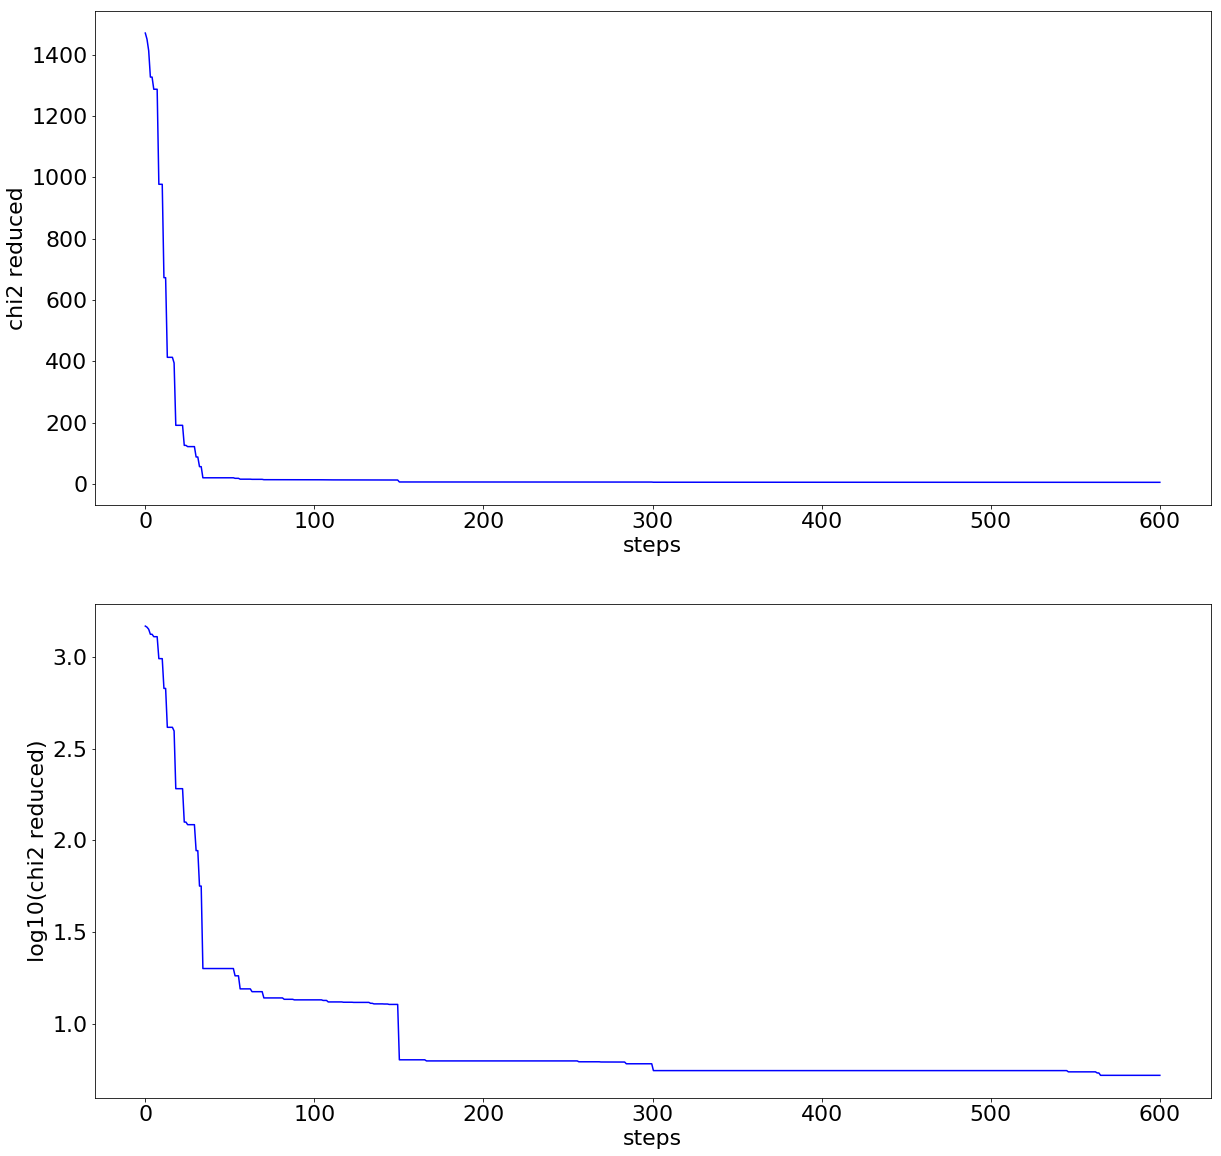

In [1454]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('chi2 reduced')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(chi2 reduced)')
plt.xlabel('steps')

In [1396]:
zparameters=minchain[0:8]
globalparameters=minchain[8:23]
inputimage=sci_image
var_inputimage=var_image
single_image_analysis=ZernikeFitter_PFS(sci_image,var_image)
single_image_analysis.initParams(zmax) 
x=LN_PFS_single(sci_image,var_image).create_x(zparameters,globalparameters)
for i in range(len(columns)):
    single_image_analysis.params[columns[i]].set(x[i])
res_iapetus = single_image_analysis.constructModelImage_PFS_naturalResolution(single_image_analysis.params)

chi**2 reduced is: 13.3208306875
Abs of residual divided by total flux is: 0.0671084529132
Abs of residual divided by largest value of a flux in the image is: 0.0525731516985


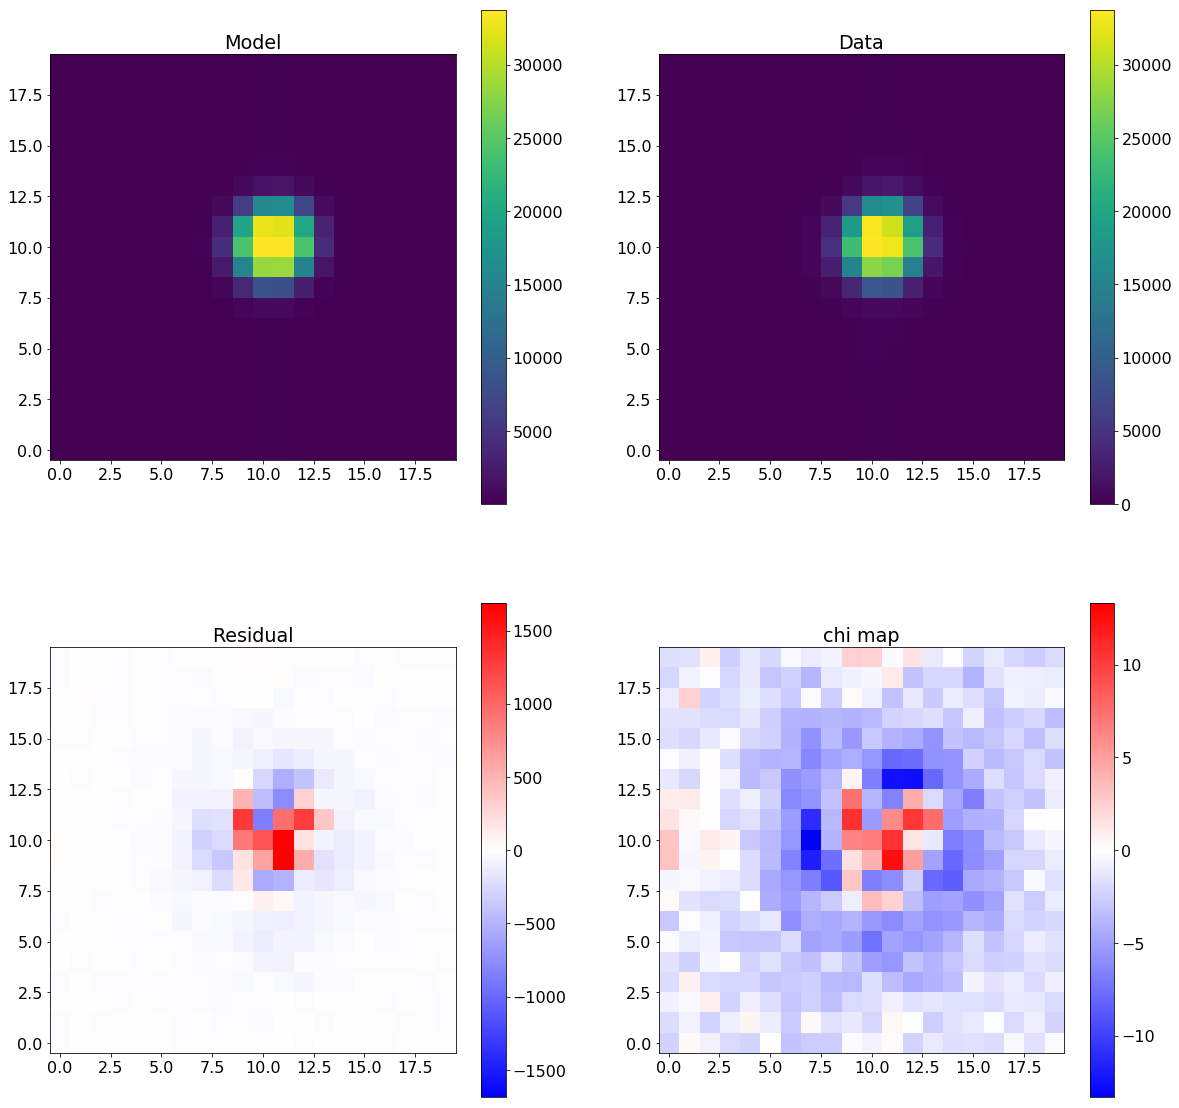

In [1397]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-inputimage,origin='lower',cmap='bwr',vmin=-np.max(np.abs(inputimage))/20,vmax=np.max(np.abs(inputimage))/20)
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)/np.sqrt(var_inputimage),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))),vmin=-np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))))
plt.colorbar()
plt.title('chi map')
print('chi**2 reduced is: '+str(np.sum((res_iapetus-inputimage)**2/((var_inputimage.shape[0]*var_inputimage.shape[1])*var_inputimage))))
print('Abs of residual divided by total flux is: '+str(np.sum(np.abs((res_iapetus-inputimage)))/np.sum((res_iapetus))))
print('Abs of residual divided by largest value of a flux in the image is: '+str(np.max(np.abs((res_iapetus-inputimage)/np.max(res_iapetus)))))

13.3208306875


0.067108452913245492

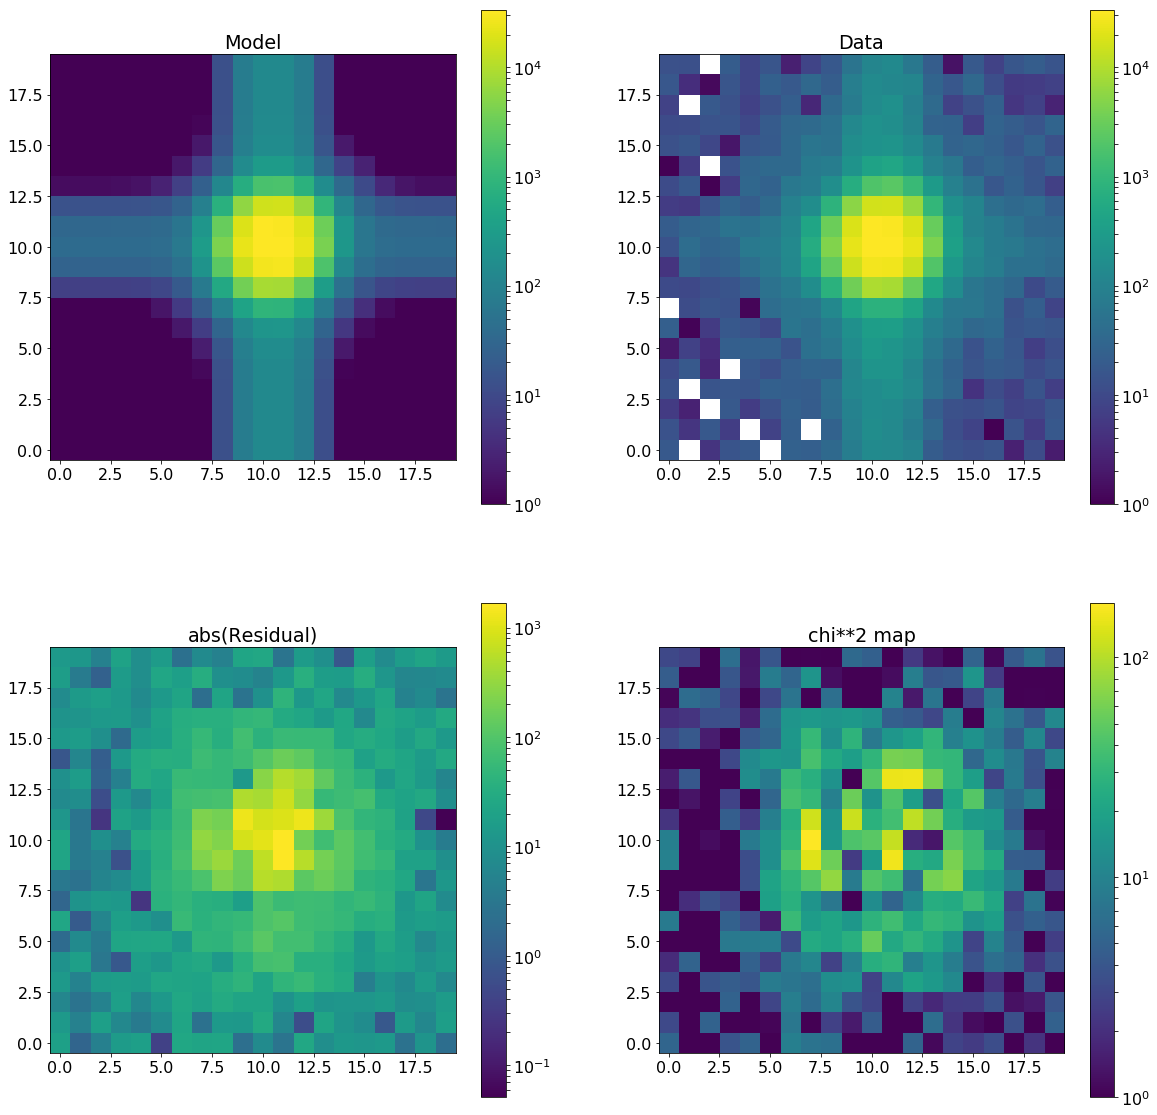

In [1398]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmin=1,vmax=np.max(np.abs(inputimage)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmin=1,vmax=np.max(np.abs(inputimage)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus-inputimage),origin='lower',vmax=np.max(np.abs(inputimage))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)**2/((1)*var_inputimage),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-inputimage)**2/((var_inputimage.shape[0]*var_inputimage.shape[1])*var_inputimage)))
np.sum(np.abs((res_iapetus-inputimage)))/np.sum((res_iapetus))